# Group 4 Mathematics and Programming in Artificail intelligence

# Table of Contents:

1. [Why CIFAR-10](#why-cifar-10)
2. Task 1: NumPy Neural Network Implementation
   - [Activation Functions](#Activation-Functions)
   - [Softmax Layer](#Softmax-Layer)
   - [Dropout Implementation](#Dropout-Implementation)
   - [Neural Network Class](#neural-network-class)
   - [Optimisers](#optimisers)
   - [Network Evaluation and Results](#network-evaluation-and-results)
3. Task 2: PyTorch Implementation
   - [Dataset Preparation](#dataset-preparation)
   - [Evaluations which will be used to measure performance of each CNN variant](#evaluations-which-will-be-used-to-measure-performance-of-each-cnn-variant)
   - [Model Description and Implementation](#model-description-and-implementation)
   - [Improved model](#improved-model)
   - [optimised hyperparameters](#optimised-hyperparameters)
   - [Results and Discussion](#results-and-discussion)
4. [Conclusion and Reflection](#conclusion-and-reflection)

# Why CIFAR-10

We chose CIFAR-10 dataset due to its complexity and suitability in evaluating multi-layer neural networks. It holds 60,000 32x32 colour images spanning 10 diverse classes, crescendoing in a challenging classification task surpassing the likes of datasets like MNIST, which only holds grayscale digits. CIFAR-10 includes RGB images, demanding models to learn from more detailed and complex data, mirroring real world applications, where data is diverse and high dimensional. The aforementioned complexity allows rigorous testing of network architectures, activation functions, and techniques to optimise the model. Lastly, it has well documented benchmarks, and  widespread use in academic research making it a top candidate to showcase advanced implementations, setting the ground work for meaningful comparisons and evaluations.

## Imports:

In [48]:
#imports 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import tensorflow as tf

import torch, torchvision, time, gc, random

from torch.utils.data import DataLoader,random_split, ConcatDataset
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# Task 1: NumPy Neural Network Implementation 

## Activation functions

### sigmoid functions and ReLU

ReLU Forward Output: [0 0 0 1 2]
ReLU Backward Output: [0.  0.  0.  0.4 0.5]
ReLU Forward Test: Passed
ReLU Backward Test: Passed

Sigmoid Forward Output: [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
Sigmoid Backward Output: [0.01049936 0.03932239 0.075      0.07864477 0.05249679]
Sigmoid Forward Test: Passed
Sigmoid Backward Test: Passed

Tanh Forward Output: [-0.96402758 -0.76159416  0.          0.76159416  0.96402758]
Tanh Backward Output: [0.00706508 0.08399487 0.3        0.16798974 0.03532541]
Tanh Forward Test: Passed
Tanh Backward Test: Passed

Leaky ReLU Forward Output: [-0.02 -0.01  0.    1.    2.  ]
Leaky ReLU Backward Output: [0.001 0.002 0.003 0.4   0.5  ]
Leaky ReLU Forward Test: Passed
Leaky ReLU Backward Test: Passed


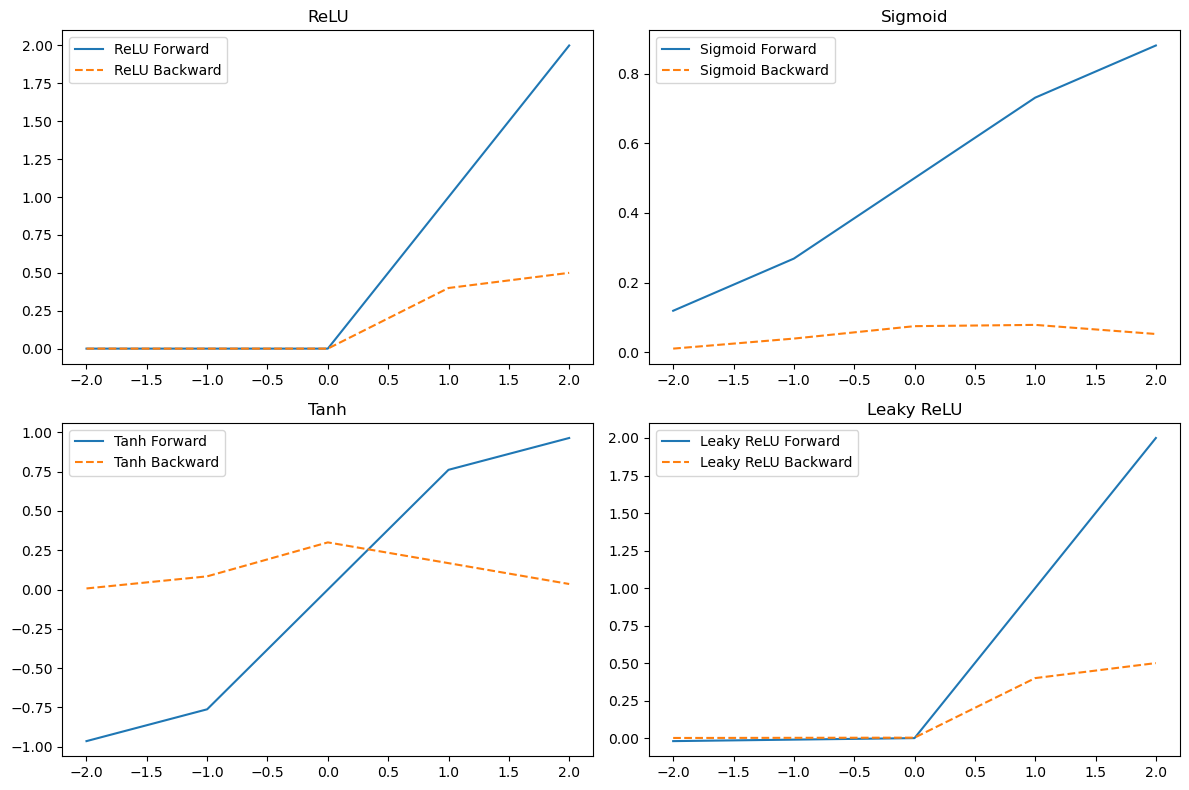

In [83]:
class ActivationFunction:
    def __init__(self, activationFunction):
        validActivation = ["sigmoid", "relu", "tanh", "leaky_relu"]
        if activationFunction not in validActivation:
            raise ValueError(f"{activationFunction} is not a valid activation function!")
        self.activationFunction = activationFunction

    def __reluForward(self, x):
        '''
        does the forward pass of the ReLU function
        x is the input arry 
        and then it outputs a tuple with the result of the  ReLU forward pass as well a cache used for backward pass
        cache this time is the input array 
        '''
        out = np.maximum(0, x)
        return out, x

    def __reluBackward(self, dout, cache):
        '''
        backward pass of the ReLU function
        x is just passing on the inpui arrat from forward pass using cache as the temporary store 
        dx is the gradient of the loss in respect to the input (being the array x)
        dout is the upstream gradient 
        '''
        # Ensure inputs are numpy arrays
        dout = np.array(dout)
        
        # Handle case where cache might be None
        if cache is None:
            raise ValueError("Cache cannot be None in reluBackward")
        
        x = np.array(cache)
        
        dx = dout * (x > 0) #derivative is 1 when x >0 otherwise it is 0
        return dx

    def __sigmoidForward(self, x):
        '''
        this function does the forward pass of the sigmoid function
        it takes an input array i just called x 
        and it returns a tuple with the result (out) of the sigmoid function
        as well as cache which we use in the backward pass, its just the same as the out 
        '''
        out = 1 / (1 + np.exp(-x)) # The sigmoid function
        cache = out
        return out, cache

    def __sigmoidBackward(self, dout, cache):
        '''
        does the backward pass of the sigmoid function
        i used d to show that its the derivative 
        so dx is the gradient of the loss with resepct to x (the input array)
        dout is the upstream gradient
        sig is just the sigmoid function hence why it equals cache
        '''
        # Ensure inputs are numpy arrays
        dout = np.array(dout)

        # Handle case where cache might be None
        if cache is None:
            raise ValueError("Cache cannot be None in sigmoidBackward")
        
        sig = np.array(cache)
        
        # Compute gradient
        dx = dout * sig * (1 - sig) # The derivative of the sigmoid function multiplied by the upstream gradient to get the proper flow of gradients
        return dx

    def __tanhForward(self, x):
        out = np.tanh(x) 
        cache = out 
        return out, cache

    def __tanhBackward(self, dout, cache):
        if cache is None:
            raise ValueError("Cache cannot be None in tanhBackward")
        tanh_val = np.array(cache)
        dx = dout * (1 - tanh_val ** 2)
        return dx

    def __leakyReluForward(self, x, alpha=0.01):
        """Forward pass for Leaky ReLU."""
        out = np.where(x > 0, x, alpha * x)
        cache = (x, alpha)
        return out, cache

    def __leakyReluBackward(self, dout, cache):
        """Backward pass for Leaky ReLU."""
        if cache is None:
            raise ValueError("Cache cannot be None in leakyReluBackward")
        x, alpha = cache
        dx = dout * np.where(x > 0, 1, alpha)
        return dx

    def forward(self, x):
        if self.activationFunction == "relu":
            return self.__reluForward(x)
        elif self.activationFunction == "sigmoid":
            return self.__sigmoidForward(x)
        elif self.activationFunction == "tanh":
            return self.__tanhForward(x)
        elif self.activationFunction == "leaky_relu":
            return self.__leakyReluForward(x)

    def backward(self, dout, cache):
        if self.activationFunction == "relu":
            return self.__reluBackward(dout, cache)
        elif self.activationFunction == "sigmoid":
            return self.__sigmoidBackward(dout, cache)
        elif self.activationFunction == "tanh":
            return self.__tanhBackward(dout, cache)
        elif self.activationFunction == "leaky_relu":
            return self.__leakyReluBackward(dout, cache)

if __name__ == "__main__":
    # Test cases for each activation function
    test_input = np.array([-2, -1, 0, 1, 2])
    dout = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

    # Expected outputs (forward and backward pass)
    expected_relu_out = np.array([0, 0, 0, 1, 2])
    expected_relu_dx = np.array([0. , 0. , 0. , 0.4, 0.5])

    expected_sigmoid_out = np.array([0.11920292, 0.26894142, 0.5, 0.73105858, 0.88079708])
    expected_sigmoid_dx = np.array([0.01049936, 0.03932239, 0.075, 0.07864477, 0.05249679])

    expected_tanh_out = np.array([-0.96402758, -0.76159416, 0., 0.76159416, 0.96402758])
    expected_tanh_dx = np.array([0.00706508, 0.08399487, 0.3, 0.16798974, 0.03532541])

    expected_leaky_relu_out = np.array([-0.02, -0.01, 0., 1., 2.])
    expected_leaky_relu_dx = np.array([0.001, 0.002, 0.003, 0.4, 0.5])

    # Relu
    relu = ActivationFunction("relu")
    relu_out, relu_cache = relu.forward(test_input)
    relu_dx = relu.backward(dout, relu_cache)

    # Sigmoid
    sigmoid = ActivationFunction("sigmoid")
    sigmoid_out, sigmoid_cache = sigmoid.forward(test_input)
    sigmoid_dx = sigmoid.backward(dout, sigmoid_cache)

    # Tanh
    tanh = ActivationFunction("tanh")
    tanh_out, tanh_cache = tanh.forward(test_input)
    tanh_dx = tanh.backward(dout, tanh_cache)

    # Leaky ReLU
    leaky_relu = ActivationFunction("leaky_relu")
    leaky_relu_out, leaky_relu_cache = leaky_relu.forward(test_input)
    leaky_relu_dx = leaky_relu.backward(dout, leaky_relu_cache)

    # Print results
    print("ReLU Forward Output:", relu_out)
    print("ReLU Backward Output:", relu_dx)
    print("ReLU Forward Test:", "Passed" if np.allclose(relu_out, expected_relu_out) else "Failed")
    print("ReLU Backward Test:", "Passed" if np.allclose(relu_dx, expected_relu_dx) else "Failed")

    print("\nSigmoid Forward Output:", sigmoid_out)
    print("Sigmoid Backward Output:", sigmoid_dx)
    print("Sigmoid Forward Test:", "Passed" if np.allclose(sigmoid_out, expected_sigmoid_out) else "Failed")
    print("Sigmoid Backward Test:", "Passed" if np.allclose(sigmoid_dx, expected_sigmoid_dx) else "Failed")

    print("\nTanh Forward Output:", tanh_out)
    print("Tanh Backward Output:", tanh_dx)
    print("Tanh Forward Test:", "Passed" if np.allclose(tanh_out, expected_tanh_out) else "Failed")
    print("Tanh Backward Test:", "Passed" if np.allclose(tanh_dx, expected_tanh_dx) else "Failed")

    print("\nLeaky ReLU Forward Output:", leaky_relu_out)
    print("Leaky ReLU Backward Output:", leaky_relu_dx)
    print("Leaky ReLU Forward Test:", "Passed" if np.allclose(leaky_relu_out, expected_leaky_relu_out) else "Failed")
    print("Leaky ReLU Backward Test:", "Passed" if np.allclose(leaky_relu_dx, expected_leaky_relu_dx) else "Failed")

    # Plot results
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(test_input, relu_out, label="ReLU Forward")
    plt.plot(test_input, relu_dx, label="ReLU Backward", linestyle="--")
    plt.title("ReLU")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(test_input, sigmoid_out, label="Sigmoid Forward")
    plt.plot(test_input, sigmoid_dx, label="Sigmoid Backward", linestyle="--")
    plt.title("Sigmoid")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(test_input, tanh_out, label="Tanh Forward")
    plt.plot(test_input, tanh_dx, label="Tanh Backward", linestyle="--")
    plt.title("Tanh")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(test_input, leaky_relu_out, label="Leaky ReLU Forward")
    plt.plot(test_input, leaky_relu_dx, label="Leaky ReLU Backward", linestyle="--")
    plt.title("Leaky ReLU")
    plt.legend()

    plt.tight_layout()
    plt.show()


## Softmax Layer

Testing Softmax Layer

Softmax Forward:
 [[0.65900114 0.24243297 0.09856589]
 [0.11314284 0.8360188  0.05083836]]
Softmax Backward:
 [[ 0.32950057 -0.37878351  0.04928295]
 [ 0.05657142 -0.0819906   0.02541918]]

Forward Pass Test: Passed
Backward Pass Test: Passed


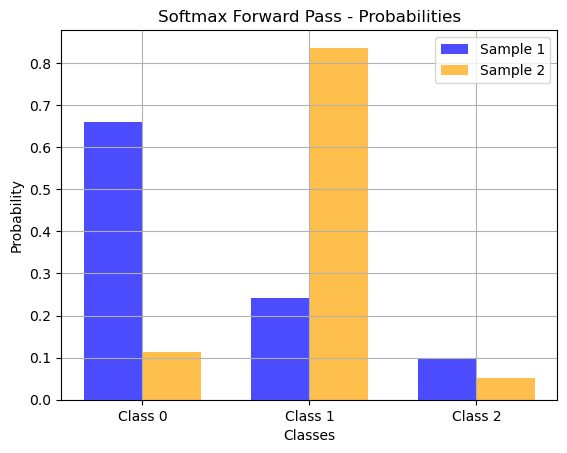

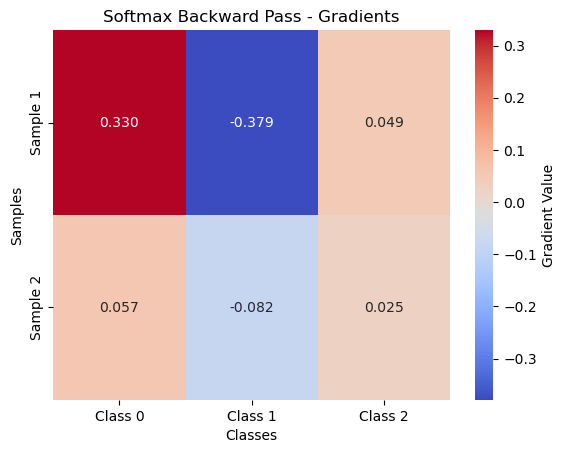

In [84]:
class SoftmaxLayer:
    
    def __init__(self):
        # Prepare to store the output of the softmax function
        self.output = None

    @staticmethod
    def softmaxForward(logits):
        """
        Perform the forward pass to calculate softmax probabilities.
    
        Parameters:
            logits (np.array): Scores from the previous layer, shaped (batch_size, num_classes).
            
        Returns:
            np.array: Probabilities for each class, same shape as input.
        """
        # Subtract the max to keep numbers stable
        z_max = np.max(logits, axis=1, keepdims=True)
        shifted_logits = logits - z_max
        exp_shifted = np.exp(shifted_logits)
        
        # Divide by sum of exponents to get probabilities
        sum_exp = np.sum(exp_shifted, axis=1, keepdims=True)
        output = exp_shifted / sum_exp
        return output

    @staticmethod
    def softmaxBackward(output, true_labels):
        """
        Perform the backward pass to calculate gradient of the loss.
    
        Parameters:
            output (np.array): Probabilities from softmaxForward, shaped (batch_size, num_classes).
            true_labels (np.array): One-hot encoded true class labels, shaped (batch_size, num_classes).
            
        Returns:
            np.array: Gradient of the loss with respect to logits, same shape as input.
        """
        # Get the number of samples to average the gradient
        num_samples = true_labels.shape[0]
        
        # Calculate the gradient for softmax combined with cross-entropy
        gradient = (output - true_labels) / num_samples
        return gradient

if __name__ == "__main__":
    print("Testing Softmax Layer\n")
    # Test inputs for Softmax
    logits = np.array([[2.0, 1.0, 0.1],
                       [1.0, 3.0, 0.2]])
    true_labels = np.array([[0, 1, 0],
                             [0, 1, 0]])

    # Expected results
    expected_forward = np.array([[0.65900114, 0.24243297, 0.09856589],
                                  [0.11314284, 0.8360188, 0.05083836]])
    expected_backward = np.array([[ 0.32950057, -0.37878351,  0.04928295],
                                   [ 0.05657142, -0.0819906,   0.02541918]])

    # Forward pass for Softmax
    softmax_layer = SoftmaxLayer()
    softmax_out = softmax_layer.softmaxForward(logits)
    print("Softmax Forward:\n", softmax_out)

    # Compare forward output to expected
    forward_passed = np.allclose(softmax_out, expected_forward, atol=1e-6)
    

    # Backward pass for Softmax
    softmax_dx = softmax_layer.softmaxBackward(softmax_out, true_labels)
    print("Softmax Backward:\n", softmax_dx)

    # Compare backward output to expected
    backward_passed = np.allclose(softmax_dx, expected_backward, atol=1e-6)


    print("\nForward Pass Test:", "Passed" if forward_passed else "Failed")
    print("Backward Pass Test:", "Passed" if backward_passed else "Failed")

    # Plot Forward Outputs for Softmax
    plt.figure()
    bar_width = 0.35
    indices = np.arange(len(softmax_out[0]))  # Number of classes

    plt.bar(indices - bar_width / 2, softmax_out[0], bar_width, label="Sample 1", color="blue", alpha=0.7)
    plt.bar(indices + bar_width / 2, softmax_out[1], bar_width, label="Sample 2", color="orange", alpha=0.7)

    plt.title("Softmax Forward Pass - Probabilities")
    plt.xlabel("Classes")
    plt.ylabel("Probability")
    plt.xticks(indices, [f"Class {i}" for i in range(len(softmax_out[0]))])
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Backward Gradients for Softmax as a Heatmap
    plt.figure()
    sns.heatmap(softmax_dx, annot=True, fmt=".3f", cmap="coolwarm", xticklabels=[f"Class {i}" for i in range(softmax_dx.shape[1])], yticklabels=["Sample 1", "Sample 2"], cbar_kws={"label": "Gradient Value"})
    plt.title("Softmax Backward Pass - Gradients")
    plt.xlabel("Classes")
    plt.ylabel("Samples")
    plt.show()


## Dropout Implementation 

Testing Dropout
Dropout Forward (Training):
 [[1.25 2.5  3.75]
 [5.   0.   0.  ]]
Dropout Forward (Testing):
 [[1. 2. 3.]
 [4. 5. 6.]]
Dropout Forward Test (Training Mode): Passed
Dropout Forward Test (Testing Mode): Passed
Dropout Backward Test: Passed


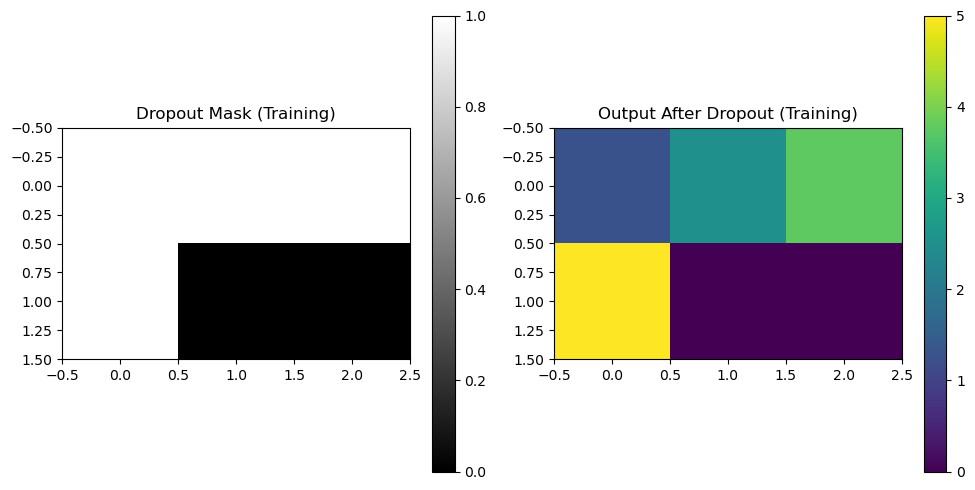

In [85]:
class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, x, training):
        """
        Forward pass for dropout.
        Args:
            x (numpy array): The input to the dropout layer.
            training (bool): Is the model being trained.
        Returns:
            numpy array: Output after applying dropout.
        """
        if not isinstance(x, np.ndarray):
            raise TypeError(f"Input must be a numpy array, but got {type(x).__name__}.")
    
        if training:
            self.mask = (np.random.rand(*x.shape) > self.dropout_rate)
            return x * self.mask / (1 - self.dropout_rate)
        return x

    def backward(self, dout):
        """
        Backward pass for dropout.
        Args:
            dout (numpy array): The gradient from the next layer.
        Returns:
            numpy array: Gradient after applying dropout mask.
        """
        return dout * self.mask / (1 - self.dropout_rate)

if __name__ == "__main__":
    np.random.seed(42)  # For reproducibility
    print("Testing Dropout")

    # Test inputs for Dropout
    x_dropout = np.array([[1.0, 2.0, 3.0],
                          [4.0, 5.0, 6.0]])
    dropout_rate = 0.2

    # Initialize Dropout layer
    dropout_layer = Dropout(dropout_rate)

    # Forward pass for Dropout
    dropout_out_training = dropout_layer.forward(x_dropout, training=True)
    dropout_out_testing = dropout_layer.forward(x_dropout, training=False)

    print("Dropout Forward (Training):\n", dropout_out_training)
    print("Dropout Forward (Testing):\n", dropout_out_testing)

    # Check scaling during training
    expected_scaling = (x_dropout * dropout_layer.mask) / (1.0 - dropout_rate)
    forward_train_passed = np.allclose(dropout_out_training, expected_scaling, atol=1e-6)
    print("Dropout Forward Test (Training Mode):", "Passed" if forward_train_passed else "Failed")

    # Check if output during testing matches input
    forward_test_passed = np.allclose(dropout_out_testing, x_dropout, atol=1e-6)
    print("Dropout Forward Test (Testing Mode):", "Passed" if forward_test_passed else "Failed")

    # Backward pass for Dropout
    dout_dropout = np.ones_like(x_dropout)
    dropout_dx = dropout_layer.backward(dout_dropout)

    # Check gradients during backward pass
    expected_gradients = dout_dropout * dropout_layer.mask / (1.0 - dropout_rate)
    backward_passed = np.allclose(dropout_dx, expected_gradients, atol=1e-6)
    print("Dropout Backward Test:", "Passed" if backward_passed else "Failed")

    plt.figure(figsize=(10, 5))

    # Plot dropout mask
    plt.subplot(1, 2, 1)
    plt.title("Dropout Mask (Training)")
    plt.imshow(dropout_layer.mask.astype(int), cmap='gray', interpolation='nearest', vmin=0, vmax=1) 
    plt.colorbar()

    # Plot output after dropout
    plt.subplot(1, 2, 2)
    plt.title("Output After Dropout (Training)")
    plt.imshow(dropout_out_training, cmap='viridis', interpolation='none')
    plt.colorbar()

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

## Batch Normalisation 

Forward output:
[[-1.22474258 -1.22474258]
 [ 0.          0.        ]
 [ 1.22474258  1.22474258]]

Backward gradient w.r.t input:
[[-4.59276743e-07 -4.59276743e-07]
 [ 0.00000000e+00  0.00000000e+00]
 [ 4.59276743e-07  4.59276743e-07]]

Gradient w.r.t gamma:
[[0.48989703 0.48989703]]

Gradient w.r.t beta:
[[0.9 1.2]]

Forward Pass:  Passed
Backward Pass:  Passed
Gamma Gradient:  Passed
Beta Gradient:  Passed


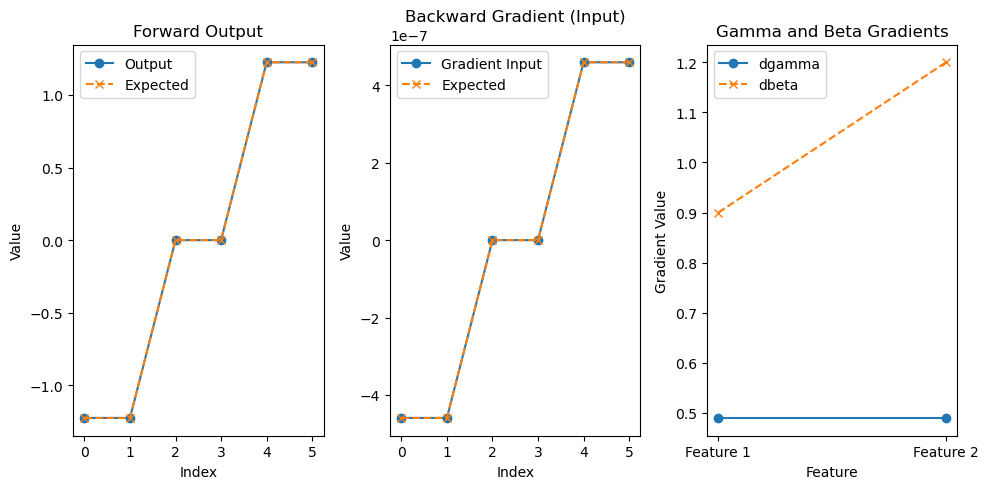

In [86]:
class BatchNormalisation:
    def __init__(self, input_dim, epsilon=1e-5, momentum=0.9):
        """
        Initializes the Batch Normalization layer.

        Args:
            input_dim (int): The dimension of the input features.
            epsilon (float): A small number to avoid division by zero.
            momentum (float): Momentum for the running mean and variance.
        """
        self.gamma = np.ones((1, input_dim)) # Scale parameter
        self.beta = np.zeros((1, input_dim)) # Shift parameter
        self.epsilon = epsilon  
        self.momentum = momentum 

        # Running mean and variance (used during inference)
        self.running_mean = np.zeros((1, input_dim))
        self.running_var = np.ones((1, input_dim))

    def forward(self, x, training=True):
        """
        Forward pass for batch normalization.

        Args:
            x (numpy.ndarray): Input data of shape (batch_size, input_dim).
            training (bool): If True, updates the running mean/variance and normalizes using batch stats.

        Returns:
            numpy.ndarray: Batch-normalized output.
        """
        if training:
            # Calculate batch mean and variance
            batch_mean = np.mean(x, axis=0, keepdims=True) 
            batch_var = np.var(x, axis=0, keepdims=True) 

            # Precompute the inverse standard deviation for numerical efficiency
            self.inv_std = 1.0 / np.sqrt(batch_var + self.epsilon)

            # Normalize the batch: x_norm = (x - mean) / std
            self.x_norm = (x - batch_mean) * self.inv_std

            # Scale and shift using gamma and beta
            out = self.gamma * self.x_norm + self.beta

            # Update the running mean and variance for inference
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var

            # Cache values for the backward pass
            self.cache = (x, batch_mean, self.inv_std, batch_var)
            return out
        else:
            # Normalize using running mean and variance during inference
            x_norm = (x - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            return self.gamma * x_norm + self.beta

    def backward(self, dout):
        """
        Backward pass for batch normalization.

        Args:
            dout (numpy.ndarray): Gradient of the loss with respect to the output, shape (batch_size, input_dim).

        Returns:
            numpy.ndarray: Gradient of the loss with respect to the input, shape (batch_size, input_dim).
        """
        # Unpack cached values from the forward pass
        x, mean, inv_std, var = self.cache
        m = x.shape[0]  # Batch size

        # Compute intermediate values
        x_mu = x - mean  # Deviation of input from the mean

        # Gradient of the normalized input with respect to the loss
        dx_norm = dout * self.gamma

        # Gradient with respect to variance
        dvar = -0.5 * np.sum(dx_norm * x_mu * inv_std**3, axis=0, keepdims=True)

        # Gradient with respect to mean
        dmean = (
            np.sum(-dx_norm * inv_std, axis=0, keepdims=True) +
            dvar * np.mean(-2.0 * x_mu, axis=0, keepdims=True)
        )

        # Gradient with respect to the input
        dx = dx_norm * inv_std + dvar * 2.0 * x_mu / m + dmean / m

        # Gradients with respect to the scale and shift parameters
        self.dgamma = np.sum(dout * self.x_norm, axis=0, keepdims=True) 
        self.dbeta = np.sum(dout, axis=0, keepdims=True)  

        return dx

if __name__ == "__main__":
    np.random.seed(42)  # For reproducibility
    # Input data
    x = np.array([
        [1.0, 2.0], 
        [3.0, 4.0], 
        [5.0, 6.0]
        ]) 
    # Gradient w.r.t output
    dout = np.array([
        [0.1, 0.2], 
        [0.3, 0.4], 
        [0.5, 0.6]])  

    # Expected outputs
    expected_forward = np.array([[-1.22474258, -1.22474258], [0.0, 0.0], [1.22474258, 1.22474258]])
    expected_backward = np.array([[-4.59276743e-07, -4.59276743e-07], [0.0, 0.0], [4.59276743e-07, 4.59276743e-07]])
    expected_dgamma = np.array([[0.48989703, 0.48989703]])
    expected_dbeta = np.array([[0.9, 1.2]])

    batch_norm = BatchNormalisation(input_dim=2)

    # Forward pass
    output = batch_norm.forward(x, training=True)
    print("Forward output:")
    print(output)

    # Backward pass
    gradient_input = batch_norm.backward(dout)
    print("\nBackward gradient w.r.t input:")
    print(gradient_input)

    # Print gradients of gamma and beta
    print("\nGradient w.r.t gamma:")
    print(batch_norm.dgamma)

    print("\nGradient w.r.t beta:")
    print(batch_norm.dbeta)

    print("\nForward Pass: ", "Passed" if np.allclose(output, expected_forward, atol=1e-5) else "Failed")
    print("Backward Pass: ", "Passed" if np.allclose(gradient_input, expected_backward, atol=1e-5) else "Failed")
    print("Gamma Gradient: ", "Passed" if np.allclose(batch_norm.dgamma, expected_dgamma, atol=1e-5) else "Failed")
    print("Beta Gradient: ", "Passed" if np.allclose(batch_norm.dbeta, expected_dbeta, atol=1e-5) else "Failed")


    # Plot forward output vs expected
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Forward Output")
    plt.plot(output.flatten(), label="Output", marker='o')
    plt.plot(expected_forward.flatten(), label="Expected", linestyle="--", marker='x')
    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Value")

    # Plot backward gradient vs expected
    plt.subplot(1, 3, 2)
    plt.title("Backward Gradient (Input)")
    plt.plot(gradient_input.flatten(), label="Gradient Input", marker='o')
    plt.plot(expected_backward.flatten(), label="Expected", linestyle="--", marker='x')
    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Value")

    # Plot gradients of gamma and beta as line plots
    plt.subplot(1, 3, 3)
    plt.title("Gamma and Beta Gradients")
    plt.plot(batch_norm.dgamma.flatten(), label="dgamma", marker='o')
    plt.plot(batch_norm.dbeta.flatten(), label="dbeta", linestyle="--", marker='x')
    plt.legend()
    plt.xlabel("Feature")
    plt.xticks(range(2), ["Feature 1", "Feature 2"])
    plt.ylabel("Gradient Value")

    plt.tight_layout()
    plt.show()

## Optimisers

In [160]:
import numpy as np

class Optimiser:
    def __init__(self, learning_rate=0.001, decay=0.0):
        """
        Initialize the optimiser with hyperparameters:
        - learning_rate: Initial step size for parameter updates.
        - decay: Learning rate decay factor (optional).
        """
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.decay = decay

    def update_weights(self, weights, gradients):
        raise NotImplementedError("This method should be implemented by subclasses.")

    def update_learning_rate(self, epoch):
        """
        Update the learning rate using exponential decay.
        """
        if self.decay > 0:
            self.learning_rate = self.initial_learning_rate / (1 + self.decay * epoch)
            
    def get_learning_rate(self, epoch):
        if self.decay > 0:
            return self.initial_learning_rate / (1 + self.decay * epoch)
        return self.initial_learning_rate

class AdamOptimiser(Optimiser):
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, decay=0.0):
        """
        Initialize the Adam optimiser with hyperparameters:
        - learning_rate: Step size for parameter updates.
        - beta1: Exponential decay rate for the first moment estimate.
        - beta2: Exponential decay rate for the second moment estimate.
        - epsilon: Small constant for numerical stability.
        - decay: Learning rate decay factor (optional).
        """
        super().__init__(learning_rate, decay)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # First moment vector (mean of gradients).
        self.v = {}  # Second moment vector (mean of squared gradients).
        self.t = 0   # Time step counter.

    def update_weights(self, weights, gradients):
        """
        Update weights using the Adam optimisation algorithm.

        Args:
        - weights: Current weights of the layer.
        - gradients: Gradients of the loss with respect to weights.

        Returns:
        - Updated weights.
        """
        if id(weights) not in self.m:
            # Initialize first and second moment vectors for the given weights.
            self.m[id(weights)] = np.zeros_like(weights)
            self.v[id(weights)] = np.zeros_like(weights)

        # Increment time step.
        self.t += 1

        # Update biased first and second moment estimates.
        self.m[id(weights)] = self.beta1 * self.m[id(weights)] + (1 - self.beta1) * gradients
        self.v[id(weights)] = self.beta2 * self.v[id(weights)] + (1 - self.beta2) * (gradients ** 2)

        # Correct bias in first and second moment estimates.
        m_hat = self.m[id(weights)] / (1 - self.beta1 ** self.t)
        v_hat = self.v[id(weights)] / (1 - self.beta2 ** self.t)

        # Update weights using the corrected moment estimates.
        weights_update = self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        weights -= weights_update

        return weights

class SGDMomentumOptimiser(Optimiser):
    def __init__(self, learning_rate=0.001, momentum=0.9, decay=0.0):
        """
        Initialize the SGD optimiser with momentum:
        - learning_rate: Step size for parameter updates.
        - momentum: Factor for exponential decay of the velocity term.
        - decay: Learning rate decay factor (optional).
        """
        super().__init__(learning_rate, decay)
        self.momentum = momentum
        self.velocity = {}

    def update_weights(self, weights, gradients):
        """
        Update weights using the SGD with Momentum algorithm.

        Args:
        - weights: Current weights of the layer.
        - gradients: Gradients of the loss with respect to weights.

        Returns:
        - Updated weights.
        """
        if id(weights) not in self.velocity:
            self.velocity[id(weights)] = np.zeros_like(weights)

        # Update velocity using momentum and gradients.
        self.velocity[id(weights)] = self.momentum * self.velocity[id(weights)] - self.learning_rate * gradients
        weights += self.velocity[id(weights)]

        return weights

class SGDOptimiser(Optimiser):
    def __init__(self, learning_rate=0.001, decay=0.0):
        """
        Initialize the SGD optimiser with optional learning rate decay.
        - learning_rate: Step size for parameter updates.
        - decay: Learning rate decay factor (optional).
        """
        super().__init__(learning_rate, decay)

    def update_weights(self, weights, gradients):
        """
        Update weights using the basic Stochastic Gradient Descent algorithm.

        Args:
        - weights: Current weights of the layer.
        - gradients: Gradients of the loss with respect to weights.

        Returns:
        - Updated weights.
        """
        weights -= self.learning_rate * gradients
        return weights

## Multi Layer Network

In [190]:
class NeuralNetwork:
    def __init__(self, activationFunction, input_size, output_size, hidden_units, dropout_rate, optimiser, epoch, batch_size, l2_lambda=0.0): # patience, tolerance 
        print("Initializing the Neural Network...")
        
        # Ensure reproducibility of results!!! Spec requirement. 
        np.random.seed(42)
        random.seed(42)
        
        # Parameters and hyperparameters initialisation 
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate

        self.output_size = output_size

        self.weights = []
        self.biases = []
        self.dropout_layers = []
        self.batch_norm_layers = []
        self.loss_values = []

        self.activationFunction = ActivationFunction(activationFunction)
        self.optimiser = optimiser

        self.epoch = epoch
        self.batch_size = batch_size
        
        # L2 regularization parameter
        self.l2_lambda = l2_lambda

        layer_sizes = [input_size] + hidden_units + [self.output_size]
        for i in range(len(layer_sizes) - 1):

            # He initialization for weights
            weights = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2 / layer_sizes[i])
            biases = np.zeros((1, layer_sizes[i + 1]))
            
            self.weights.append(weights)
            self.biases.append(biases)

            # Add dropout to hidden layers only
            if i < len(layer_sizes) - 2:  
                self.dropout_layers.append(Dropout(self.dropout_rate))

            # Add batch normalization layers to hidden layers only
            if i < len(layer_sizes) - 2:
                self.batch_norm_layers.append(BatchNormalisation(layer_sizes[i + 1]))
        print("Neural Network Ready!")
    
    def __repr__(self):
        return (
            f"NeuralNetwork(activationFunction={self.activationFunction}, "
            f"hidden_units={self.hidden_units}, "
            f"dropout_rate={self.dropout_rate}, "
            f"l2_lambda={self.l2_lambda}, "
            f"optimiser={self.optimiser}, "
            f"epoch={self.epoch}, "
            f"batch_size={self.batch_size})"
        )


             
    def forward(self, input_vector, training=True):
        """
        Perform forward propagation through the network.
        Args:
            input_vector: The input data (features).
            training: Boolean flag indicating whether the network is in training mode 
                      (to apply dropout) or evaluation mode (no dropout).
        Returns:
            output: The softmax probabilities for the output layer.
        """
        self.cache = {"A0": input_vector}
        
        # Forward pass through all hidden layers
        for i, (weight, bias) in enumerate(zip(self.weights[:-1], self.biases[:-1])):
            # Compute linear transformation Z = input data * weight + bias
            z = np.dot(self.cache[f"A{i}"], weight) + bias

            # Apply activation function
            activation, cache = self.activationFunction.forward(z)

            # Apply batch normalization
            if i < len(self.batch_norm_layers):
                activation = self.batch_norm_layers[i].forward(activation, training=training)

            # Apply dropout
            if training and i < len(self.dropout_layers):
                activation = self.dropout_layers[i].forward(activation, training=training)

            self.cache[f"Z{i + 1}"] = cache
            self.cache[f"A{i + 1}"] = activation

        # Forward pass through the output layer
        z_output = np.dot(self.cache[f"A{len(self.weights) - 1}"], self.weights[-1]) + self.biases[-1]
        output = SoftmaxLayer.softmaxForward(z_output)
        self.cache["Z_output"] = z_output
        return output

    def backward(self, forward_output, target_vector):
        """
        Perform backpropagation to compute gradients and update weights and biases.
        Args:
            forward_output: The predicted probabilities from the forward pass (softmax output).
            target_vector: The true labels in one-hot encoded format.
        """
        grads = {}
        dz_output = SoftmaxLayer.softmaxBackward(forward_output, target_vector)
        # Gradients for the output layer weights and biases
        grads[f"dW{len(self.weights) - 1}"] = np.dot(self.cache[f"A{len(self.weights) - 1}"].T, dz_output)
        grads[f"db{len(self.weights) - 1}"] = np.sum(dz_output, axis=0, keepdims=True)

        # Backpropagate the error to the previous layer
        dout = np.dot(dz_output, self.weights[-1].T)

        # Backpropagation through all hidden layers in reverse order (excluding output layer)
        for i in reversed(range(len(self.weights) - 1)):
            if i < len(self.dropout_layers):
                dout = self.dropout_layers[i].backward(dout)

            if i < len(self.batch_norm_layers):
                dout = self.batch_norm_layers[i].backward(dout)

            dz = self.activationFunction.backward(dout, self.cache[f"Z{i + 1}"])

            grads[f"dW{i}"] = np.dot(self.cache[f"A{i}"].T, dz) + self.l2_lambda * self.weights[i]
            grads[f"db{i}"] = np.sum(dz, axis=0, keepdims=True)

            dout = np.dot(dz, self.weights[i].T)
            
        # Update weights and biases using the optimiser
        for i in range(len(self.weights)):
            self.weights[i] = self.optimiser.update_weights(self.weights[i], grads[f"dW{i}"])
            self.biases[i] = self.optimiser.update_weights(self.biases[i], grads[f"db{i}"]) 

    def train(self, input_vector, target_vector, x_val, y_val, return_val_accuracy=False): #, patience, tolerance):
        """
        Train the neural network on the provided dataset.

        Args:
            input_vector (numpy.ndarray): Training data features.
            target_vector (numpy.ndarray): Training data labels in one-hot encoded format.
            x_val (numpy.ndarray): Validation data features.
            y_val (numpy.ndarray): Validation data labels in one-hot encoded format.
            epochs (int): Number of training epochs.
            batch_size (int): Size of mini-batches for training.
        """
        # Log the size of the training dataset
        print(f"Training dataset size: {input_vector.shape[0]} samples")

        # Initialize lists to store validation losses and accuracies
        self.val_losses = []
        self.val_accuracies = []
        self.train_losses = []
        self.train_accuracies = [] 

        # Total number of samples in the training data
        num_samples = input_vector.shape[0]
        batch_indices = np.arange(0, num_samples, self.batch_size)
        print(f"Total batches per epoch: {len(batch_indices)}")


        print("\nTraining the Neural Network...")
        print(f"Using optimizer: {self.optimiser.__class__.__name__}") 
        for epoch in range(self.epoch):
            # Update learning rate at the start of each epoch based on the original value passed in as an argument to be used during the first epoch
            self.optimiser.update_learning_rate(epoch)

            epoch_start = time.time()
            # Shuffle the dataset to ensure randomness in mini-batch selection
            np.random.seed(42)  # Ensure reproducibility of results!!! Spec requirement. 
            perm = np.random.permutation(num_samples)
            input_vector, target_vector = input_vector[perm], target_vector[perm]

            # Tracks the total loss for the current epoch
            epoch_loss = 0
            # Tracks the total time spent on batches in the current epoch
            batch_time_total = 0

            for start_idx in batch_indices:
                # Track the start time of processing this batch
                batch_start = time.time()
                end_idx = min(start_idx + self.batch_size, num_samples)
                x_batch = input_vector[start_idx:end_idx]
                y_batch = target_vector[start_idx:end_idx]

                # Perform forward propagation to compute predictions for the batch
                output = self.forward(x_batch, training=True)
                self.backward(output, y_batch)

                # Compute the batch loss using cross-entropy
                batch_loss = -np.mean(np.sum(y_batch * np.log(output + 1e-8), axis=1))

                # Apply L2 regularization
                l2_penalty = (self.l2_lambda / 2) * sum(np.sum(w**2) for w in self.weights)
                batch_loss += l2_penalty
                epoch_loss += batch_loss * x_batch.shape[0]


                batch_time_total += time.time() - batch_start

            epoch_loss /= num_samples
            self.loss_values.append(epoch_loss)

            val_start = time.time()
            
            val_accuracy, val_loss = self.run(x_val, y_val, return_loss=True)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)
            val_time = time.time() - val_start
            
            train_accuracy, train_loss = self.run(input_vector, target_vector, return_loss=True)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            

            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch + 1}/{self.epoch}, "
                f"Loss: | Epoch {epoch_loss:.4f}, Train {train_loss:.4f}, Val {val_loss:.4f} | "
                f"Accuracy: | train {train_accuracy * 100:.2f}% , Val {val_accuracy * 100:.2f}% | "
                f"Time: | batch {batch_time_total:.2f}s, Val {val_time:.2f}s, Total {epoch_time:.2f}s |")
        
            # Early stopping condition: Stop if validation loss does not improve over the last 5 epochs
            if epoch > 10 and (self.val_losses[-1] > min(self.val_losses[-5:])):
                print(f"Early stopping at epoch {epoch + 1}")
                break
            
            # Clear memory
            del x_batch, y_batch, output
            gc.collect() 
            
            
    def run(self, input_data, true_labels, return_loss=False):
        """
        Evaluate the neural network on a dataset and optionally compute loss.
        
        Args:
            input_data: Input data (features), shape (num_samples, num_features).
            true_labels: True labels in one-hot encoded format, shape (num_samples, num_classes).
            return_loss: Boolean, whether to return the loss.
        
        Returns:
            accuracy: The accuracy (validation or training accuracy, depending on the values passed as inputs to the function) of the network on the given dataset as a float value. 
            loss (optional): The loss (validation or training loss, depending on the values passed as inputs to the function) on the given dataset.
        """
        output = self.forward(input_data, training=False)
        predictions = np.argmax(output, axis=1) # whether those made on the training set or the validation set, as input_data parameter could very well be x_val (validation set) or input_vector (training set), depending on whether training accuracy or validation accuracy is being calculated and therefore, depending on the arguments passed when calling function run within method train (x_val or input_vector) 
        labels = np.argmax(true_labels, axis=1) # whether labels of the training set or the validation set, as true_labels parameter could very well be y_val (validation set) or target_vector (training set), depending on whether training accuracy or validation accuracy is being calculated and therefore, depending on the arguments passed when calling function run within method train (y_val or target_vector) 

        accuracy = np.mean(predictions == labels) # whether training or validation accuracy, it will work for both. This is determined by the arguments passed when calling function run within method train, once for calculating training accuracy and once for calculating validation accuracy. 
        
        if return_loss:
            loss = -np.mean(np.sum(true_labels * np.log(output + 1e-8), axis=1)) # this can calculate both training loss and validation loss, depending on the arguments passed when calling function run within method train. If y_val is passed as an argument, validation loss is calculated. If target_vector is passed as an argument, training loss is calculated. In our implementation of method train.
            return accuracy, loss
        return accuracy

    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        epochs = range(1, len(self.loss_values) + 1)
        plt.plot(epochs, self.loss_values, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss', color='orange')
        plt.title("Training and Validation Loss Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()


    def plot_accuracy(self):
        plt.figure(figsize=(10, 6))
        epochs = range(1, len(self.train_accuracies) + 1)
        plt.plot(epochs, self.train_accuracies, label='Training Accuracy')
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy', color='orange')
        plt.title("Training and Validation Accuracy Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.show()
    
    def plot_confusion_matrix(self, input_data, true_labels, class_names):
        """
        Plot the confusion matrix for the given dataset.
        
        Args:
            input_data: Input data (features), shape (num_samples, num_features).
            true_labels: True labels in one-hot encoded format.
            class_names: List of class names corresponding to the one-hot encoding.
        """
        output = self.forward(input_data, training=False)
        predictions = np.argmax(output, axis=1)
        labels = np.argmax(true_labels, axis=1)

        cm = confusion_matrix(labels, predictions)

        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 8))

        # Plot the matrix with a blue color map
        cax = ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.7)

        # Add numerical values to each cell
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', color='black', fontsize=12)

        # Set x and y axis labels
        ax.set_xticks(range(len(class_names)))
        ax.set_yticks(range(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha="right", fontsize=10)
        ax.set_yticklabels(class_names, fontsize=10)

        # Set axis labels and title
        plt.title('Confusion Matrix', pad=20, fontsize=14)
        plt.xlabel('Predicted', fontsize=12, labelpad=10)
        plt.ylabel('True', fontsize=12, labelpad=10)

        # Adjust layout to prevent clipping
        plt.tight_layout()
        plt.show()

    def plot_precision_recall_curve(self, input_data, true_labels, class_names):
        """
        Plot the precision-recall curve for the given dataset.

        Args:
            input_data: Input data (features), shape (num_samples, num_features).
            true_labels: True labels in one-hot encoded format.
            class_names: List of class names corresponding to the one-hot encoding.
        """
        output = self.forward(input_data, training=False)
        plt.figure(figsize=(10, 6))

        # Loop through each class to calculate precision and recall
        for i, class_name in enumerate(class_names):
            precision, recall, _ = precision_recall_curve(true_labels[:, i], output[:, i])
            plt.plot(recall, precision, lw=2, label=f'{class_name}')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

    def plot_learning_rate_schedule(self):
        """
        Plot the learning rate schedule used during training.
        """
        # Adjust epoch range to start from 1
        learning_rates = [self.optimiser.get_learning_rate(epoch) for epoch in range(self.epoch)]
        epochs = range(1, self.epoch + 1)  # Start epochs at 1

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, learning_rates, label='Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.grid()
        plt.legend()
        plt.show()

    def plot_roc_curve(self, input_data, true_labels, class_names):
        """
        Plot the ROC curve for the given dataset.

        Args:
            input_data: Input data (features), shape (num_samples, num_features).
            true_labels: True labels in one-hot encoded format.
            class_names: List of class names corresponding to the one-hot encoding.
        """
        output = self.forward(input_data, training=False)
        plt.figure(figsize=(10, 6))

        for i, class_name in enumerate(class_names):
            fpr, tpr, _ = roc_curve(true_labels[:, i], output[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

        # Add diagonal line for chance level
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

    def generate_classification_report(self, input_data, true_labels, class_names):
        """
        Generate a classification report for the given dataset.
        
        Args:
            input_data: Input data (features), shape (num_samples, num_features).
            true_labels: True labels in one-hot encoded format.
            class_names: List of class names corresponding to the one-hot encoding.
        """
        output = self.forward(input_data, training=False)
        predictions = np.argmax(output, axis=1)
        labels = np.argmax(true_labels, axis=1)

        report = classification_report(labels, predictions, target_names=class_names)
        print("Classification Report:\n")
        print(report)

## CIFAR 10 RUNNER

In [197]:
class CIFAR10Runner:
    def __init__(self, model): 
        # Neural Network parameters
        self.model = model

        # CIFAR-10 class names
        self.class_names = [
            "airplane", "automobile", "bird", "cat", "deer",
            "dog", "frog", "horse", "ship", "truck"
        ]
        
    
    def load_data(self):
        output_size = self.model.output_size
        
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

        # Flatten images and normalize
        x_train = x_train.reshape(x_train.shape[0], -1).astype("float32") / 255.0
        x_test = x_test.reshape(x_test.shape[0], -1).astype("float32") / 255.0

        # One-hot encode labels
        y_train = tf.keras.utils.to_categorical(y_train, output_size)
        y_test = tf.keras.utils.to_categorical(y_test, output_size)

        # Split the original training set into train/validation subsets
        x_train, x_val, y_train, y_val = train_test_split(
            x_train, y_train, test_size = 0.18, random_state = 42, stratify = y_train
        )
        print(f"Training dataset size: {x_train.shape[0]}")
        print(f"Validation dataset size: {x_val.shape[0]}")
        print(f"Test dataset size: {x_test.shape[0]}")

        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test

        return x_train, y_train, x_val, y_val, x_test, y_test

    def run(self):
        """
        Train and evaluate the Neural Network.
        """
        print("Loading CIFAR-10 data...\n")
        x_train, y_train, x_val, y_val, x_test, y_test = self.load_data()
        
        self.model.train(x_train, y_train, x_val, y_val, return_val_accuracy=False)

        print("Final Evaluation on Test Set...")
        test_accuracy = self.model.run(x_test, y_test)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
             
        self.model.plot_loss()
        self.model.plot_accuracy()
        self.model.plot_confusion_matrix(self.x_test, self.y_test, class_names=self.class_names)
        self.model.plot_precision_recall_curve(self.x_test, self.y_test, class_names=self.class_names)
        self.model.plot_roc_curve(self.x_test, self.y_test, class_names=self.class_names)
        self.model.generate_classification_report(self.x_test, self.y_test, class_names=self.class_names)
        self.model.plot_learning_rate_schedule()

## Running the Neural Network

First set the optimisers

In [198]:
adamOptimiser = AdamOptimiser(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, decay=0.01)
sgdMomentumOptimiser = SGDMomentumOptimiser(learning_rate=0.001, momentum=0.9, decay=0.01)
sgdOptimiser = SGDOptimiser(learning_rate=0.001, decay=0.01) 

Create the model with adam optimiser and run it

Initializing the Neural Network...
Neural Network Ready!
Loading CIFAR-10 data...

Training dataset size: 41000
Validation dataset size: 9000
Test dataset size: 10000
Training dataset size: 41000 samples
Total batches per epoch: 321

Training the Neural Network...
Using optimizer: AdamOptimiser
Epoch 1/100, Loss: | Epoch 1.9235, Train 2.0702, Val 2.0962 | Accuracy: | train 35.90% , Val 35.23% | Time: | batch 47.80s, Val 0.47s, Total 50.43s |
Epoch 2/100, Loss: | Epoch 1.6549, Train 1.5279, Val 1.5872 | Accuracy: | train 45.42% , Val 43.82% | Time: | batch 45.58s, Val 0.47s, Total 48.21s |
Epoch 3/100, Loss: | Epoch 1.5581, Train 1.4478, Val 1.5103 | Accuracy: | train 48.47% , Val 46.73% | Time: | batch 45.67s, Val 0.47s, Total 48.31s |
Epoch 4/100, Loss: | Epoch 1.5053, Train 1.4929, Val 1.5669 | Accuracy: | train 46.95% , Val 44.57% | Time: | batch 47.77s, Val 0.48s, Total 50.51s |
Epoch 5/100, Loss: | Epoch 1.4675, Train 1.4053, Val 1.4993 | Accuracy: | train 50.24% , Val 47.12% | Ti

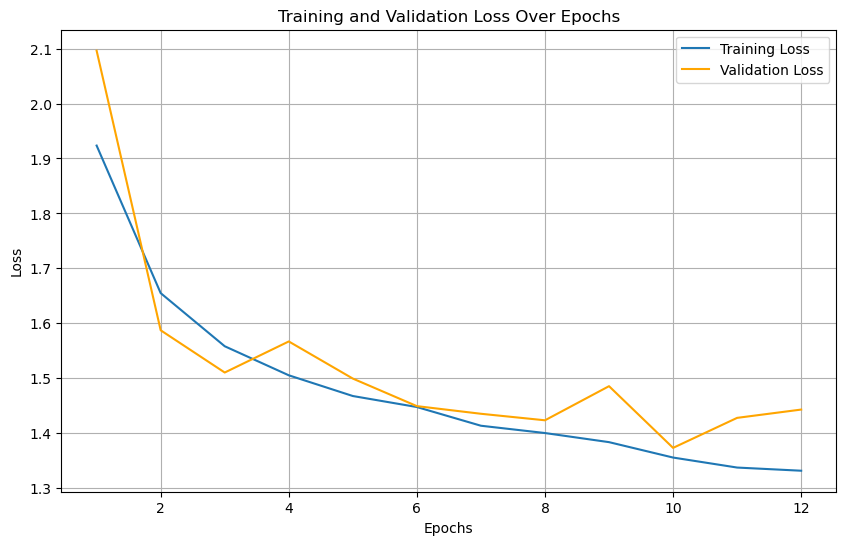

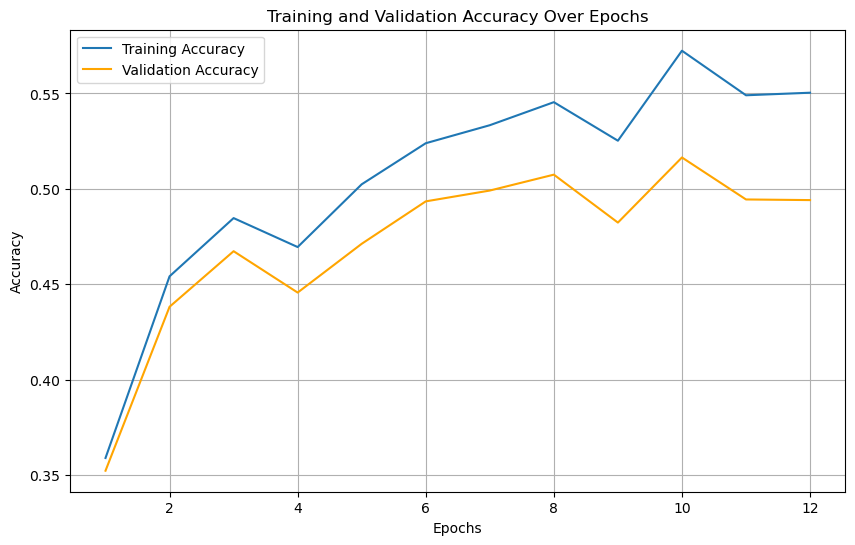

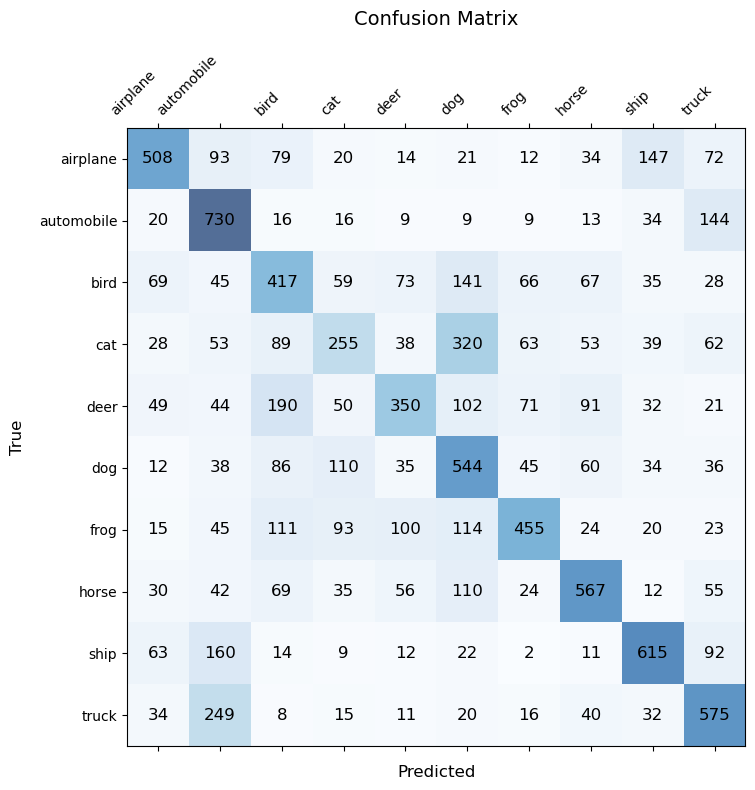

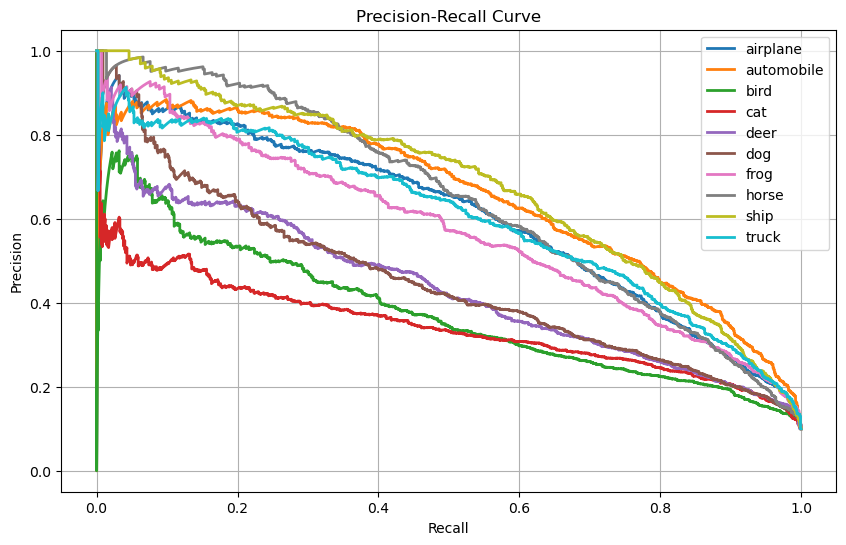

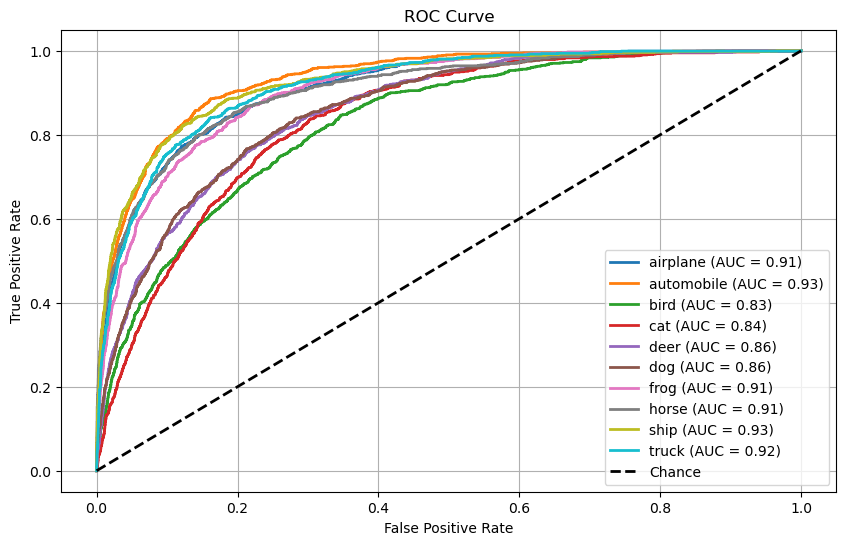

Classification Report:

              precision    recall  f1-score   support

    airplane       0.61      0.51      0.56      1000
  automobile       0.49      0.73      0.58      1000
        bird       0.39      0.42      0.40      1000
         cat       0.39      0.26      0.31      1000
        deer       0.50      0.35      0.41      1000
         dog       0.39      0.54      0.45      1000
        frog       0.60      0.46      0.52      1000
       horse       0.59      0.57      0.58      1000
        ship       0.61      0.61      0.61      1000
       truck       0.52      0.57      0.55      1000

    accuracy                           0.50     10000
   macro avg       0.51      0.50      0.50     10000
weighted avg       0.51      0.50      0.50     10000



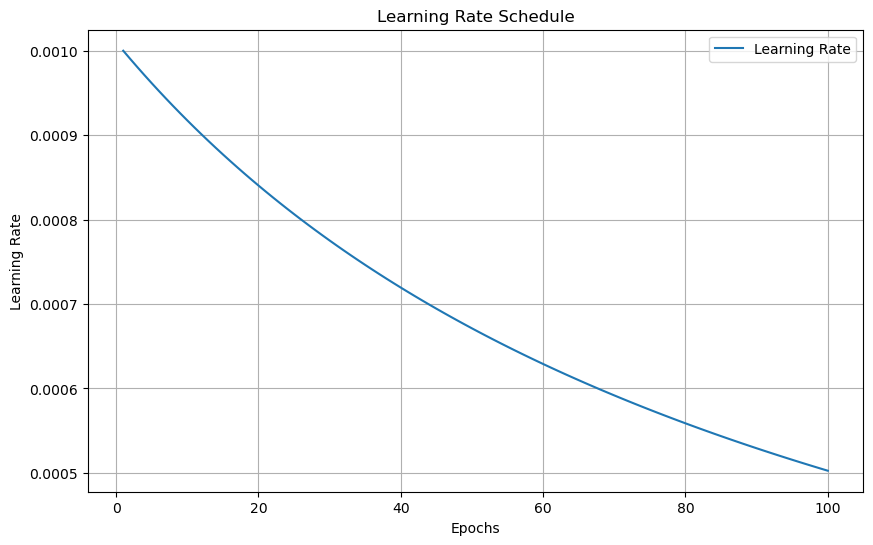

In [199]:
adamModel = NeuralNetwork(
    activationFunction="relu",
    input_size=32 * 32 * 3,
    output_size=10,
    hidden_units=[1024, 512, 256],
    dropout_rate=0.2,
    optimiser=adamOptimiser,
    l2_lambda=0.0,
    epoch = 100,
    batch_size = 128
)
adamRunner = CIFAR10Runner(model=adamModel).run()

Create the model with SGD Momentum optimiser and run it

Initializing the Neural Network...
Neural Network Ready!
Loading CIFAR-10 data...

Training dataset size: 41000
Validation dataset size: 9000
Test dataset size: 10000
Training dataset size: 41000 samples
Total batches per epoch: 321

Training the Neural Network...
Using optimizer: SGDMomentumOptimiser
Epoch 1/100, Loss: | Epoch 2.1928, Train 1.6807, Val 1.7478 | Accuracy: | train 41.18% , Val 38.52% | Time: | batch 26.19s, Val 0.48s, Total 28.92s |
Epoch 2/100, Loss: | Epoch 1.8387, Train 1.5567, Val 1.6334 | Accuracy: | train 45.29% , Val 41.94% | Time: | batch 25.52s, Val 0.47s, Total 28.20s |
Epoch 3/100, Loss: | Epoch 1.7207, Train 1.4978, Val 1.5799 | Accuracy: | train 47.42% , Val 44.17% | Time: | batch 26.54s, Val 0.49s, Total 29.26s |
Epoch 4/100, Loss: | Epoch 1.6519, Train 1.4577, Val 1.5528 | Accuracy: | train 48.55% , Val 44.71% | Time: | batch 26.53s, Val 0.48s, Total 29.21s |
Epoch 5/100, Loss: | Epoch 1.5966, Train 1.4160, Val 1.5145 | Accuracy: | train 50.35% , Val 46.0

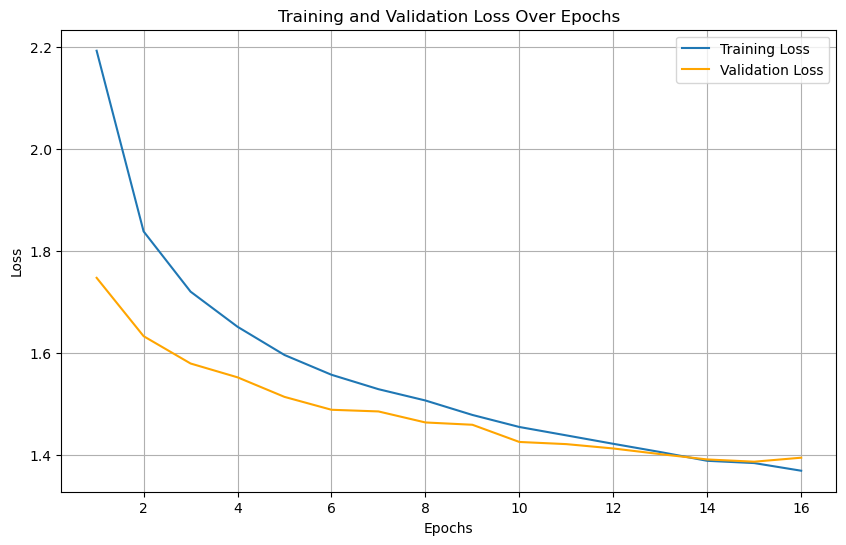

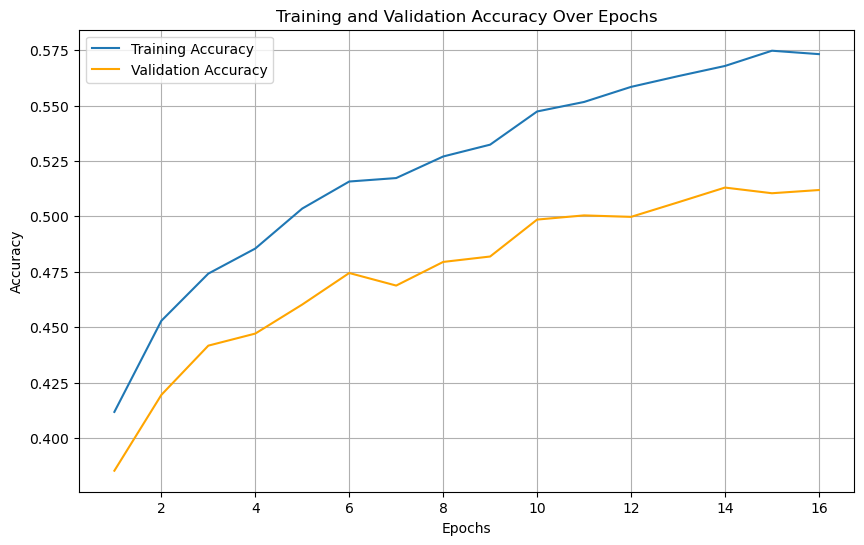

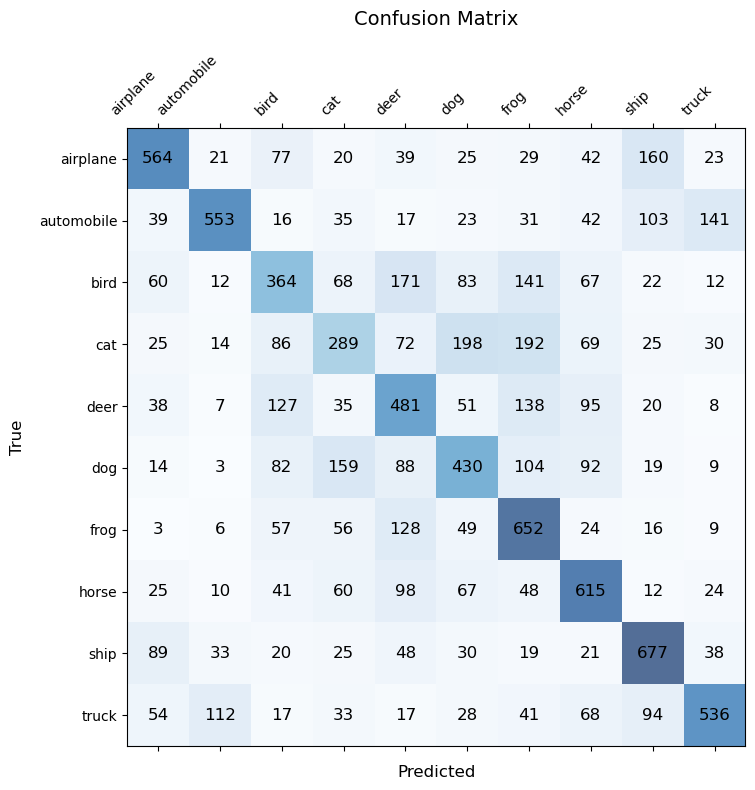

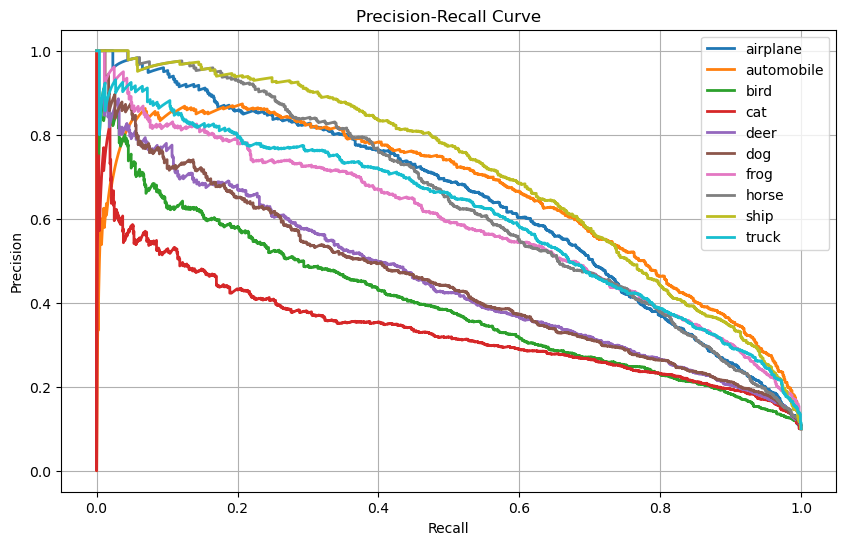

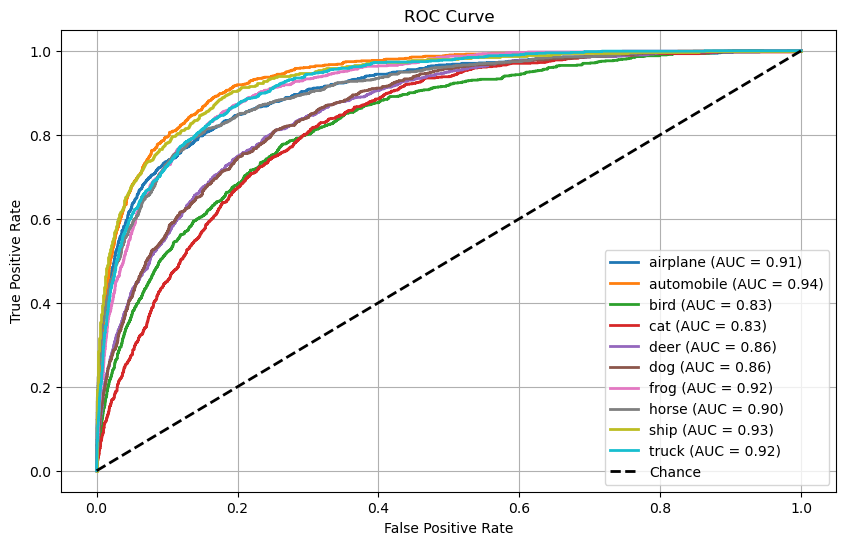

Classification Report:

              precision    recall  f1-score   support

    airplane       0.62      0.56      0.59      1000
  automobile       0.72      0.55      0.62      1000
        bird       0.41      0.36      0.39      1000
         cat       0.37      0.29      0.32      1000
        deer       0.42      0.48      0.45      1000
         dog       0.44      0.43      0.43      1000
        frog       0.47      0.65      0.54      1000
       horse       0.54      0.61      0.58      1000
        ship       0.59      0.68      0.63      1000
       truck       0.65      0.54      0.59      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.51     10000
weighted avg       0.52      0.52      0.51     10000



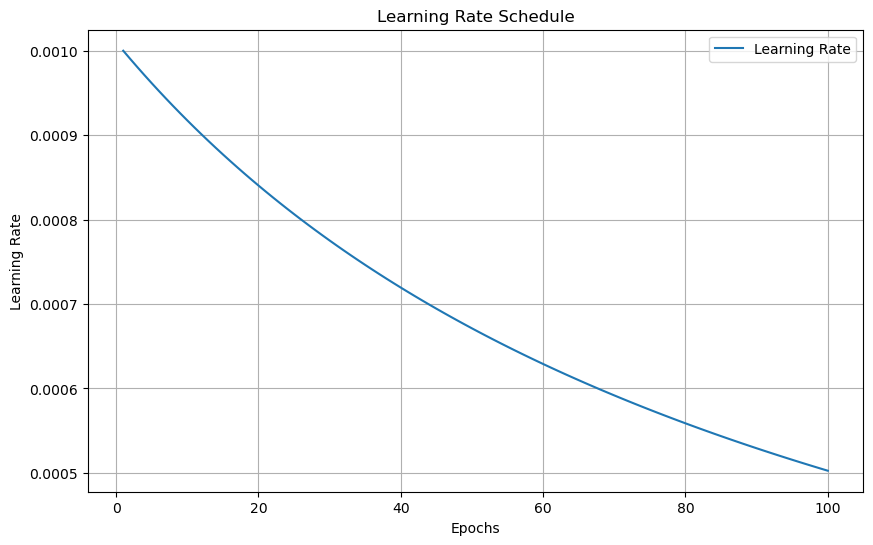

In [201]:
sgdMomentumModel = NeuralNetwork(
    activationFunction="relu",
    input_size=32 * 32 * 3,
    output_size=10,
    hidden_units=[1024, 512, 256],
    dropout_rate=0.2,
    optimiser=sgdMomentumOptimiser,
    l2_lambda=0.0,
    epoch = 100,
    batch_size = 128
)
sgdMomentumModelRunner = CIFAR10Runner(model=sgdMomentumModel).run()

Create the model with SGD optimiser and run it

Initializing the Neural Network...
Neural Network Ready!
Loading CIFAR-10 data...

Training dataset size: 41000
Validation dataset size: 9000
Test dataset size: 10000
Training dataset size: 41000 samples
Total batches per epoch: 321

Training the Neural Network...
Using optimizer: SGDOptimiser
Epoch 1/100, Loss: | Epoch 2.6730, Train 2.1270, Val 2.1790 | Accuracy: | train 28.95% , Val 27.88% | Time: | batch 23.45s, Val 0.54s, Total 26.41s |
Epoch 2/100, Loss: | Epoch 2.3223, Train 1.9285, Val 1.9962 | Accuracy: | train 34.44% , Val 32.04% | Time: | batch 22.40s, Val 0.49s, Total 25.13s |
Epoch 3/100, Loss: | Epoch 2.1833, Train 1.8423, Val 1.9119 | Accuracy: | train 36.98% , Val 34.22% | Time: | batch 22.21s, Val 0.50s, Total 25.05s |
Epoch 4/100, Loss: | Epoch 2.0989, Train 1.7830, Val 1.8681 | Accuracy: | train 38.94% , Val 35.66% | Time: | batch 23.40s, Val 0.48s, Total 26.20s |
Epoch 5/100, Loss: | Epoch 2.0373, Train 1.7211, Val 1.8103 | Accuracy: | train 40.77% , Val 37.68% | Tim

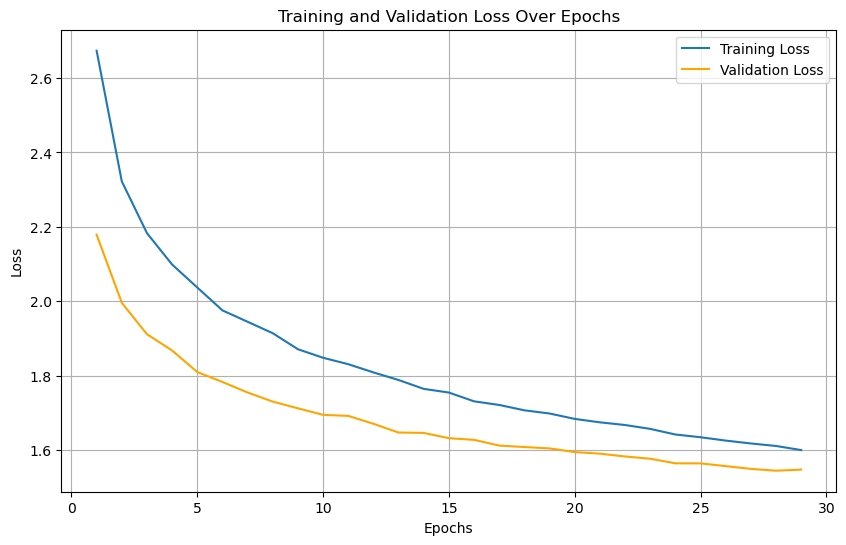

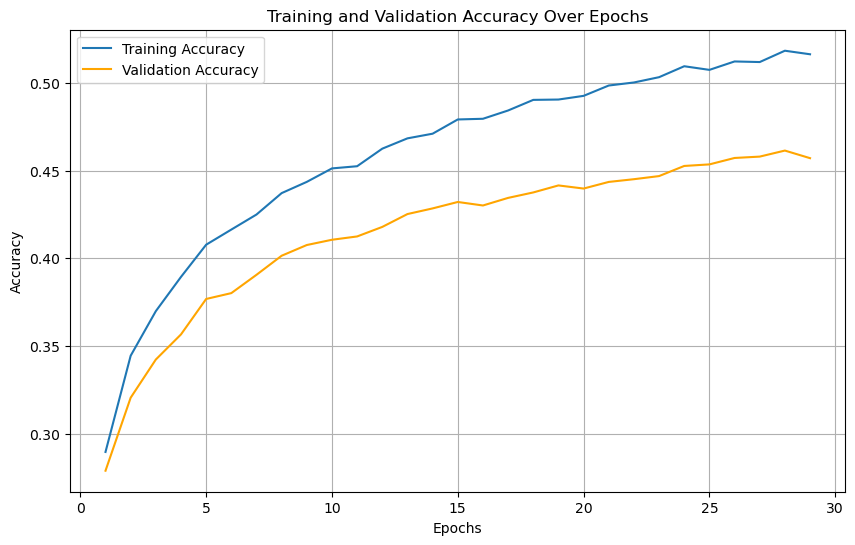

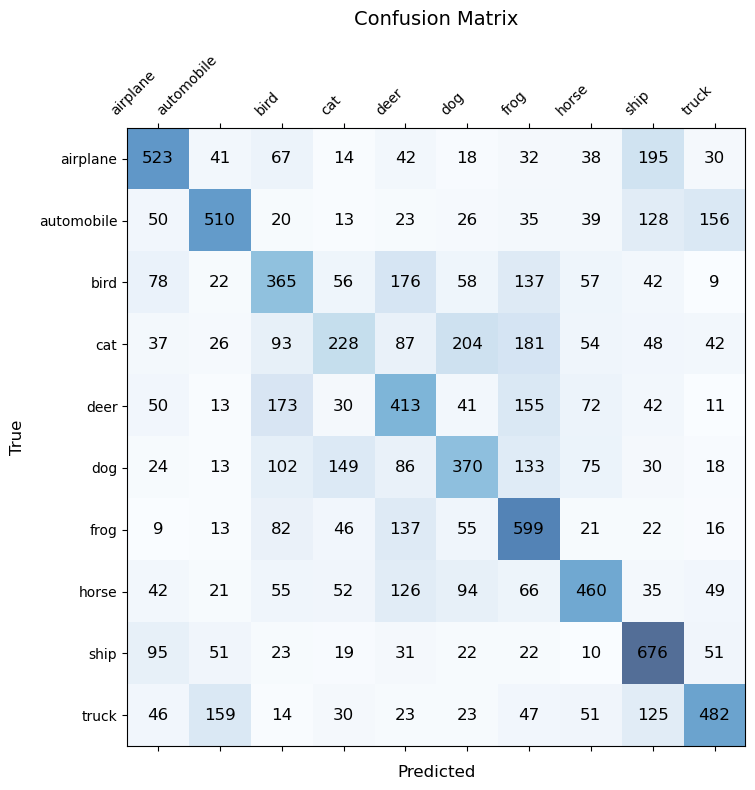

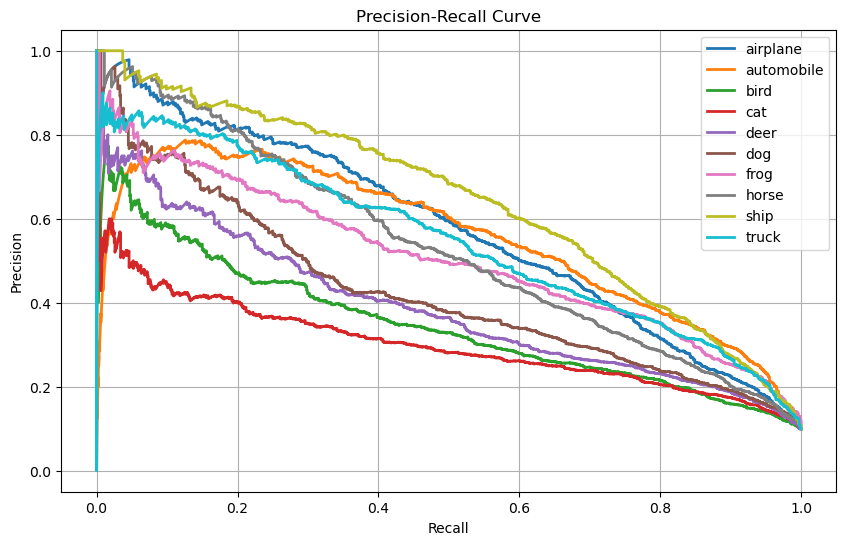

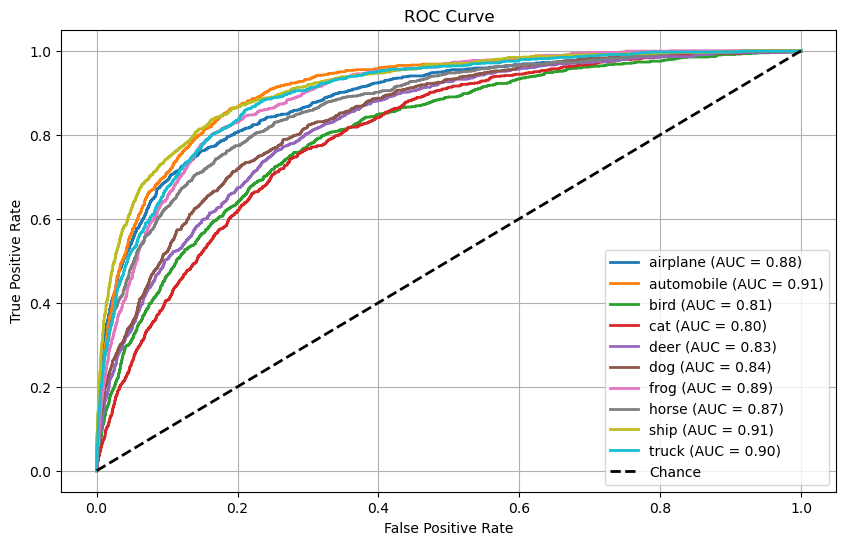

Classification Report:

              precision    recall  f1-score   support

    airplane       0.55      0.52      0.54      1000
  automobile       0.59      0.51      0.55      1000
        bird       0.37      0.36      0.37      1000
         cat       0.36      0.23      0.28      1000
        deer       0.36      0.41      0.39      1000
         dog       0.41      0.37      0.39      1000
        frog       0.43      0.60      0.50      1000
       horse       0.52      0.46      0.49      1000
        ship       0.50      0.68      0.58      1000
       truck       0.56      0.48      0.52      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     10000



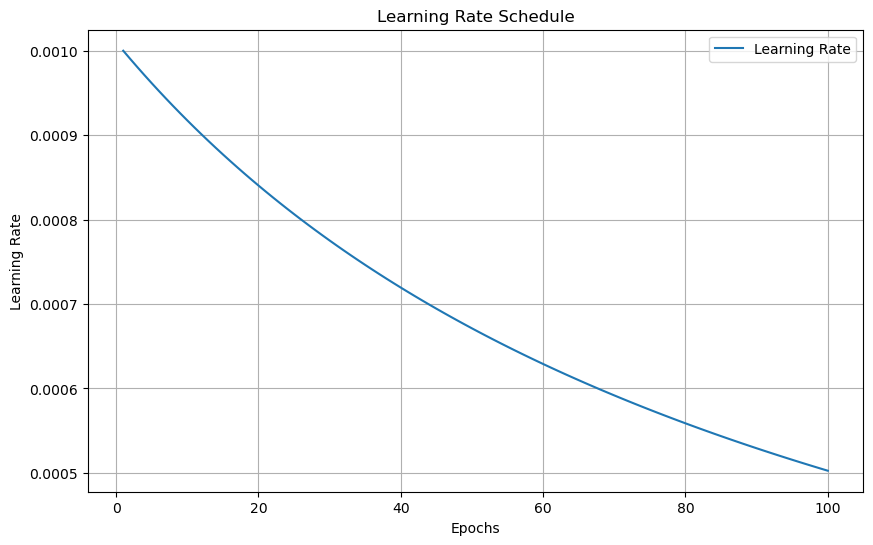

In [202]:
sdgModel = NeuralNetwork(
    activationFunction="relu",
    input_size=32 * 32 * 3,
    output_size=10,
    hidden_units=[1024, 512, 256],
    dropout_rate=0.2,
    optimiser=sgdOptimiser,
    l2_lambda=0.0,
    epoch = 100,
    batch_size = 128
)
sgdRunner = CIFAR10Runner(model=sdgModel)
sgdRunner.run()

# Task 2: PyTorch Implementation

## Dataset Preparation

In [17]:

# Check if a GPU is open, if it is use CUDA for faster computation, if not go with CPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop a patch that is 32x32 with padding, improving robustness to spatial shifts
    transforms.RandomHorizontalFlip(),  # Flip the image horizontally to augment data 
    transforms.ToTensor(),  # Convert from PIL to PyTorch tensors format
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Add color jitter to simulate varied lighting conditions
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to have a mean of 0.5 and std of 0.5 for stability
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Only normalize test data; augmentation not needed during evaluation
])

# Load CIFAR-10 dataset with the specified transformations
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


# Concatenate the training and test datasets
combined_data = ConcatDataset([train_data, test_data])

# train/validation split ratio
train_size = int(0.72 * len(combined_data))  # 72% for training
validation_size = int(0.18 * len(combined_data))  # 18% for validation
test_size = int(0.10 * len(combined_data))  # 10% for testing 

# Split the combined data into train, validate and test sets, in a randomized manner but with a fixed seed to ensure reproducibility of the results
generator = torch.Generator().manual_seed(42)
train_data, validation_data, test_data = random_split(combined_data, [train_size, validation_size, test_size], generator)

# Create data loaders for train, validation, and test sets
load_train = DataLoader(train_data, batch_size=64, shuffle=True)  # Training data is in random order to help training
load_validation = DataLoader(validation_data, batch_size=64, shuffle=False)  # No shuffling for validation data
load_test = DataLoader(test_data, batch_size=64, shuffle=False)  # No shuffling for test data


Files already downloaded and verified
Files already downloaded and verified


## Evaluations which will be used to measure performance of each CNN variant

In [18]:
# made a class with all the evaluations i will use for my models to compare and illustrate their performance 
class ModelEvaluator:
    #initialise with the attributes that we will use
    def __init__(self, model, optimiser, criterion, device, load_train, load_validation, load_test, class_labels):
        self.model = model
        self.optimiser = optimiser
        self.criterion = criterion
        self.device = device
        self.load_train = load_train
        self.load_validation = load_validation
        self.load_test = load_test
        self.class_labels = class_labels 

        #initialise empty list so that metrics can be tracked as training goes on
        self.train_losses = []
        self.validation_losses = []
        self.accuracies = []
        self.all_labels = []
        self.all_predictions = []
        self.learning_rates = []

    def store_learning_rate(self):
        lr = [group['lr'] for group in self.optimiser.param_groups] #gets the learning rate currently in use from the optimser
        self.learning_rates.append(lr[0]) #adds that to a learning rates list to visualise wehn we draw grath

    def evaluate_epoch(self, epoch):
        self.model.eval() #puts model from training to evaluation mode, turning off droupt and batch updates
        # init validation loss and counters for accuracy, also clear the previous lables and predictions for the epoch
        validation_loss = 0.0 
        correct, total = 0, 0
        self.all_labels.clear()
        self.all_predictions.clear()

        #goes through the set without calculating gradients, computes: prediction, loss anad stores the actual labels as well as the predicted labels 
        with torch.no_grad():
            for inputs, labels in self.load_validation:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                self.all_labels.extend(labels.cpu().numpy())
                self.all_predictions.extend(predicted.cpu().numpy())

        #compute the average validation loss as well as the accuracy for the epoch
        average_validation_loss = validation_loss / len(self.load_validation)
        accuracy = 100 * correct / total
        #appends those results in the lists 
        self.validation_losses.append(average_validation_loss)
        self.accuracies.append(accuracy)
        print(f"Epoch {epoch+1}: Validation Loss: {average_validation_loss:.4f}, Accuracy: {accuracy:.2f}%")

#plotting accuracy plot
    def plot_accuracy(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.accuracies)+1), self.accuracies, marker='o', linestyle='-', color='b')
        plt.title("Model Accuracy Over Training")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    
#validation loss plot 
    def plot_validation_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.validation_losses)+1), self.validation_losses, marker='o', linestyle='-', color='r')
        plt.title("Model Validation Loss Over Training")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

#training loss plot
    def plot_training_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.train_losses)+1), self.train_losses, marker='o', linestyle='-', color='g')
        plt.title("Model Training Loss Over Training")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

#confusion matrix
    def plot_confusion_matrix(self):
        #makes a confusion matrix to show the perfomance of the classification
        cm = confusion_matrix(self.all_labels, self.all_predictions)
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.7)
        #inputts the numerical values to the matrix 
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', color='black', fontsize=12)

        #addinf the lables and titles so its easy to read 
        # Use the original dataset for class labels
    

        ax.set_xticks(range(len(self.class_labels)))
        ax.set_xticklabels(self.class_labels, rotation=45, ha="right")
        ax.set_yticks(range(len(self.class_labels)))
        ax.set_yticklabels(self.class_labels)

        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    # Output a classification report
    def print_classification_report(self):
        # Use self.class_labels instead of accessing from the dataset
        report = classification_report(self.all_labels, self.all_predictions, target_names=self.class_labels)
        print("\nClassification Report:\n")
        print(report)

#plot a preciison recall curve 
    def plot_precision_recall_curve(self):
        #computes the curve for each class
        plt.figure(figsize=(10, 5))
        for i, class_name in enumerate(self.class_labels):
            precision, recall, _ = precision_recall_curve(
                np.array(self.all_labels) == i, np.array(self.all_predictions) == i
            )
            plt.plot(recall, precision, label=f'Class: {class_name}')
        #displays it 
        plt.title("Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(loc="best")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

#learning rate plot
    def plot_learning_rate(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.learning_rates)+1), self.learning_rates, marker='o', linestyle='-', color='m')
        plt.title("Learning Rate Schedule")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

#figure out the top 5 accuracy, which is good for multi-class problems 
    def calculate_top5_accuracy(self):
        correct_top5, total_top5 = 0, 0
        with torch.no_grad():
            for inputs, labels in self.load_validation:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, top5_predictions = outputs.topk(5, dim=1)
                correct_top5 += (top5_predictions == labels.unsqueeze(1)).sum().item()
                total_top5 += labels.size(0)
        top5_accuracy = 100 * correct_top5 / total_top5
        print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")

#ROC CURVE 
    def plot_roc_curve(self):
        #compute and plit teh ROC curve with the AUC score 
        labels_bin = label_binarize(self.all_labels, classes=range(len(self.class_labels)))
        plt.figure(figsize=(10, 5))
        for i, class_name in enumerate(self.class_labels):
            fpr, tpr, _ = roc_curve(labels_bin[:, i], np.array(self.all_predictions) == i)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="best")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


# CNN model 

## Model Description and Implementation

### Description
We utilised a Convolutional Neural Network (CNN) model for this task as it is degined to efficiently learn hierarchical image features from low resolutions like 32 by 32 rgb images. The model is made up of three layers, each with increasing filter sizes be that 32,64 or 128 as well as 3 by 3 kernels, each followed by batch normalisation, ReLU activation, and max-pooling which reduces spatiali dimensions while maintaining critical features. 
After the aformentioned convolution stages, the network contains two fully connected layers, the first with 256 neurons and ReLU activation, which is then followed by dropout to prevent overfitting,
the second includes 10 output neurorns representing classs probabilities for CIFAR-10's different categories.
The model we have implemented leverages standard PyTorch components as well as cross-entropy to optimise accuracy in classification problems.

### justification
A CNN architecture is well suited for a dataset like CIFAR-10 due to its inate ability to learn complex spatial hierarchies by utilising layered convolutional operations, extreacting patterns such as textures, objects, and edges. 
The chosen model balances complexity with efficiency by making use of three convolutional layers, this allows computation to remain manageable while still capturing the most essential features.
Batch normalisation enables stable and faster convergence, while making use of dropout prevents overfitting on the dataset which is relatively small.
By combining max-pooling and fully connceted layers the model is able to have an optimal tradeoff between performance and training efficiency. In my opinion this all makes the Convolutional Neural Network an effective architecture for our chosen dataset.


Epoch 1/20, Loss: 1.6504
Epoch 1: Validation Loss: 1.3214, Accuracy: 51.54%
Epoch 2/20, Loss: 1.3387
Epoch 2: Validation Loss: 1.1450, Accuracy: 59.25%
Epoch 3/20, Loss: 1.1992
Epoch 3: Validation Loss: 1.1270, Accuracy: 59.82%
Epoch 4/20, Loss: 1.1230
Epoch 4: Validation Loss: 0.9696, Accuracy: 65.69%
Epoch 5/20, Loss: 1.0494
Epoch 5: Validation Loss: 0.9600, Accuracy: 65.19%
Epoch 6/20, Loss: 1.0003
Epoch 6: Validation Loss: 0.8467, Accuracy: 70.37%
Epoch 7/20, Loss: 0.9607
Epoch 7: Validation Loss: 0.8847, Accuracy: 68.61%
Epoch 8/20, Loss: 0.9328
Epoch 8: Validation Loss: 0.7715, Accuracy: 72.45%
Epoch 9/20, Loss: 0.8934
Epoch 9: Validation Loss: 0.7564, Accuracy: 73.32%
Epoch 10/20, Loss: 0.8697
Epoch 10: Validation Loss: 0.7329, Accuracy: 73.59%
Epoch 11/20, Loss: 0.8439
Epoch 11: Validation Loss: 0.7246, Accuracy: 73.95%
Epoch 12/20, Loss: 0.8230
Epoch 12: Validation Loss: 0.7618, Accuracy: 73.69%
Epoch 13/20, Loss: 0.7940
Epoch 13: Validation Loss: 0.6910, Accuracy: 75.67%
Epoc

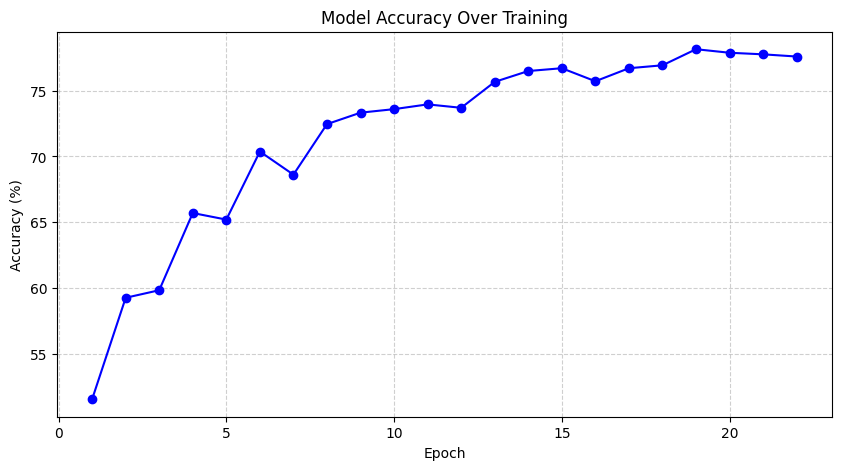

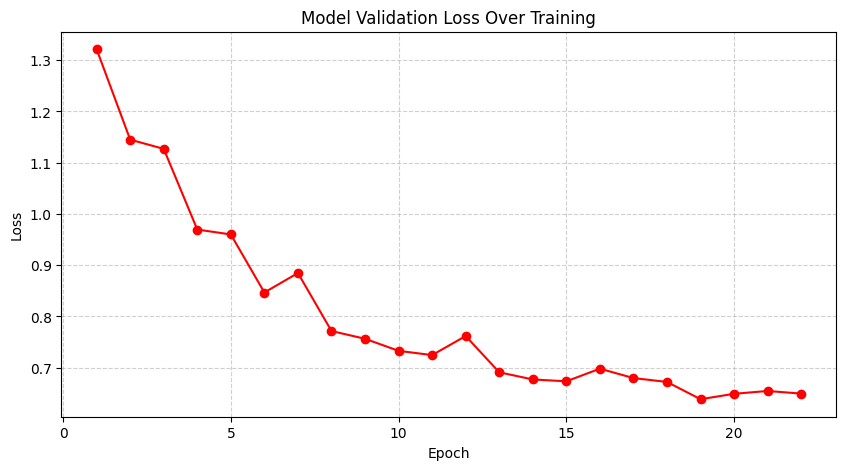

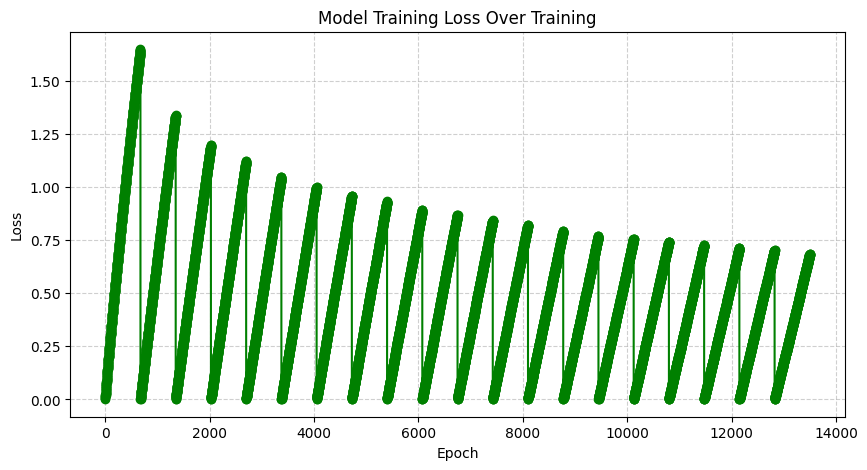

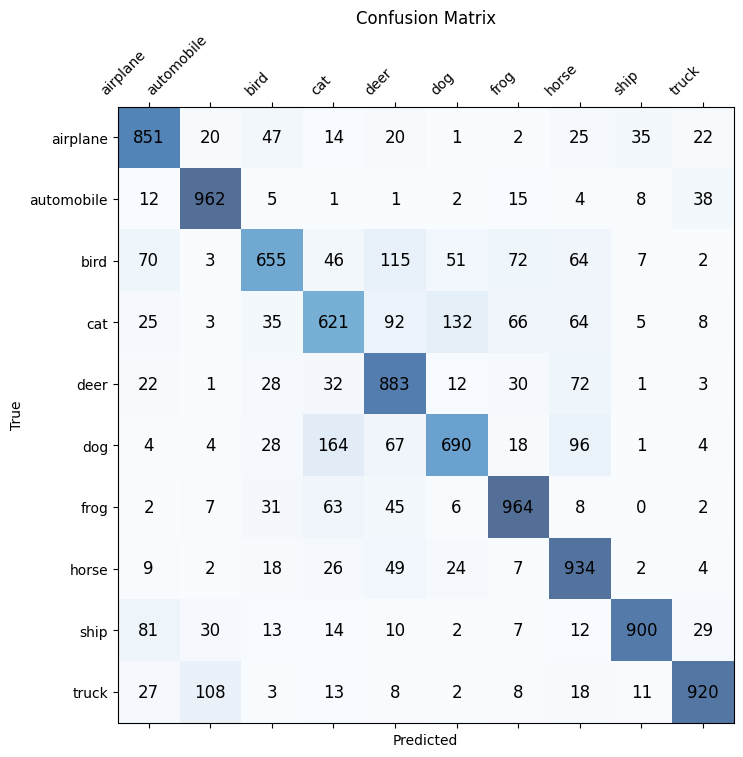


Classification Report:

              precision    recall  f1-score   support

    airplane       0.77      0.82      0.80      1037
  automobile       0.84      0.92      0.88      1048
        bird       0.76      0.60      0.67      1085
         cat       0.62      0.59      0.61      1051
        deer       0.68      0.81      0.74      1084
         dog       0.75      0.64      0.69      1076
        frog       0.81      0.85      0.83      1128
       horse       0.72      0.87      0.79      1075
        ship       0.93      0.82      0.87      1098
       truck       0.89      0.82      0.86      1118

    accuracy                           0.78     10800
   macro avg       0.78      0.78      0.77     10800
weighted avg       0.78      0.78      0.77     10800



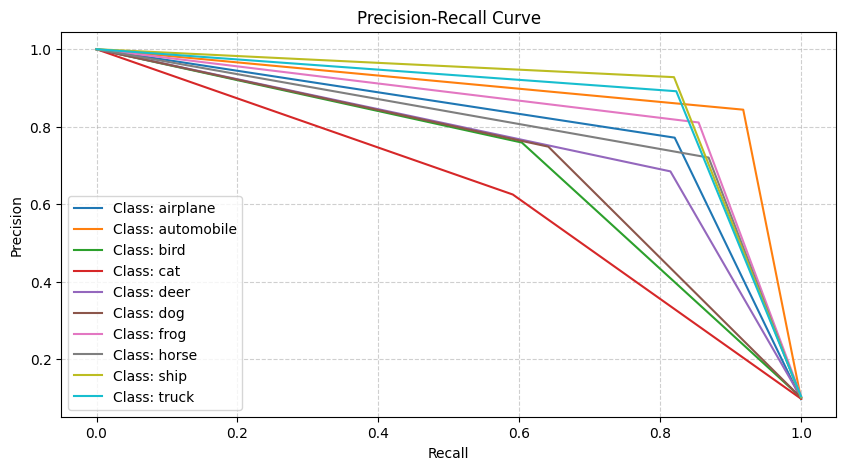

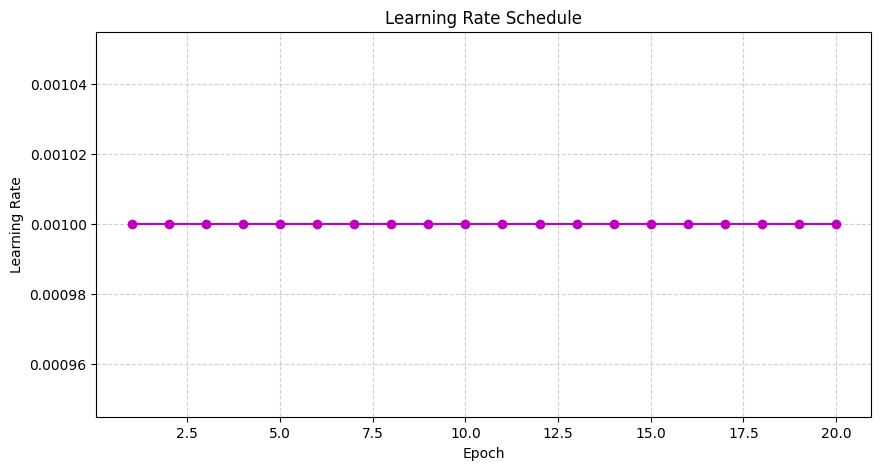

Top-5 Accuracy: 98.66%


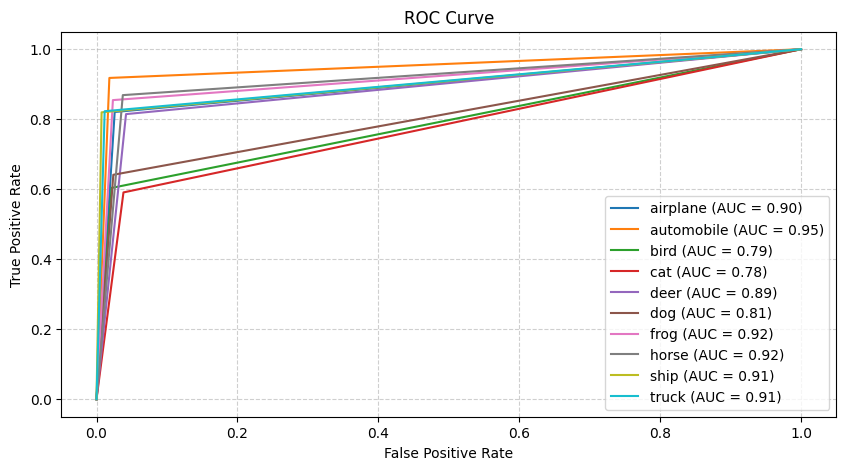

In [19]:

# defining CNNModel
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #convolutional layers 
        self.convolution1 = nn.Conv2d(3,32, kernel_size= 3, padding = 1) #conv2d applies 2d convolution
        self.normaliseBatch1 = nn.BatchNorm2d(32) #normalise each batch activation to have training be stable and speed up convergence 
        self.convolution2 = nn.Conv2d(32,64, kernel_size= 3, padding =1)
        self.normaliseBatch2 = nn.BatchNorm2d(64)
        self.convolution3 = nn.Conv2d(64,128, kernel_size=3, padding =1)
        self.normaliseBatch3 = nn.BatchNorm2d(128)
    
        self.pool = nn.MaxPool2d(2,2) #reduce dimensions, takes the max value in a 2 by 2 window, halves the width and heigth
        # fully connected layer 
        self.fc1 = nn.Linear(128 * 4 * 4, 256) #input flattend output from last convolutional layer 
        self.fc2 = nn.Linear(256, 10) # output 256 in the first layer, 10 in the last 
        self.dropout = nn.Dropout(0.5) #randomly deactive half the neurons as to not oevrfit 
        self.relu = nn.ReLU() # apply activation fucntuion relu 

    def forward(self, x):
        #the following three functions normalise activations, make it non-linear, reduce spatial dimension
        x = self.pool(self.relu(self.normaliseBatch1(self.convolution1(x)))) 
        x = self.pool(self.relu(self.normaliseBatch2(self.convolution2(x))))
        x = self.pool(self.relu(self.normaliseBatch3(self.convolution3(x))))
        x = x.view(-1, 128 * 4 * 4)  # 2d features to 1d for fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))  #regularsing the flattened output after beiong passed through the first fully connected layer
        x = self.fc2(x) #passes the output through the second fully connnected layer to get class score 
        return x #the raw prediction scores for each class in the dataaset


CNNModel = CNN().to(device) #initialise and move to the device that we prepared in the above module
criterion = nn.CrossEntropyLoss() #to get the difference between predictions and ground truth
optimiser = optim.Adam(CNNModel.parameters(), lr=0.001) #adjusts the weights in the CNNModel based on the gradients

# Extract class labels from the original dataset
class_labels = torchvision.datasets.CIFAR10(root='./data', train=True, download=False).classes
 # This will give you the class names
# Create an instance of ModelEvaluator after training
evaluator = ModelEvaluator(CNNModel, optimiser, criterion, device, load_train, load_validation, load_test, class_labels)


#loop for training
epochs = 20 #training will iterate through 20 epochs over the whole dataset
for epoch in range(epochs): #processed training for every epoch 
    CNNModel.train() #enables training and activates dropout
    running_loss = 0.0  #initiate the loss counter which will be used to calc the average loss
    for inputs, labels in load_train: #loops through the branches training data we had made in the data loader above
        inputs, labels = inputs.to(device), labels.to(device) # move both the image tensors from the current batch, and the corresponging true class lables to the selcted device
        optimiser.zero_grad() #reset gradient from previous iteration of training 
        outputs = CNNModel(inputs) #forward pass, feeds input through the cnn, generating predictions for the batch
        loss = criterion(outputs, labels) #calculating the loss function between predictions and labels using cross entropy loss 
        loss.backward() #back propagation gives us the gradient 
        optimiser.step() #update the parameters using the calculated gradient
        running_loss += loss.item() #keeps track of the average loss per epoch 
        average_train_loss = running_loss / len(load_train)
        evaluator.train_losses.append(average_train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(load_train):.4f}") #output the current average loss for the epoch

 # Evaluate on Validation Set After Each Epoch
    evaluator.evaluate_epoch(epoch)
    evaluator.store_learning_rate()

CNNModel.eval() #switch from training to evaluation

# Evaluate CNNModel on the validation set after all epochs
evaluator.evaluate_epoch(epochs - 1)

#initialise the metrics
correct = 0  #correct classifiers
total = 0 #number of imaged evaluated
with torch.no_grad(): #to save some memory prevent gradient computation while inference is running 
    for inputs, labels in load_validation: #go through test set
        inputs, labels = inputs.to(device), labels.to(device) #move the images and corresponding lables to the device selected
        outputs = CNNModel(inputs) #forward pass inputs into the cnn CNNModel, giving us a tensor with the raw prediction scores from the final layer
        _, predicted = torch.max(outputs, 1) #choose the class with the higherst prediction score, return the predicted class index, the maximum vaye itseld is not used.
        total += labels.size(0) #increase total by number of images in the batch to keep track of the ones processed
        correct += (predicted == labels).sum().item() #compare prediction with labels

final_validation_accuracy = 100 * correct / total
print(f"Final Validation Accuracy: {final_validation_accuracy:.2f}%") #prints out the calculated accuracy % to 2 decimal places

# Evaluate CNNModel on the test set
evaluator.evaluate_epoch(epochs - 1)

# Call all evaluation methods
evaluator.plot_accuracy()               # Plot Accuracy
evaluator.plot_validation_loss()        # Plot Validation Loss
evaluator.plot_training_loss()          # Plot Training Loss
evaluator.plot_confusion_matrix()       # Confusion Matrix
evaluator.print_classification_report() # Classification Report
evaluator.plot_precision_recall_curve()# Precision-Recall Curve
evaluator.plot_learning_rate()          # Learning Rate Plot
evaluator.calculate_top5_accuracy()       # Top-5 Accuracy
evaluator.plot_roc_curve()              # ROC Curve




## Improved model

### Added extra convolutinal layer
CNNs work on the principle of learning higher level features proggressively from input iages through a number of convolutional, activation, and pooling layers, each layer extracts features from the pictures at a differenat level of complexity:
The first layer looks out for basic patterns like edges, simple shapes, and textures
The second layer combines these basic patters making larger more complex features
The third layer observes more abstracts features whihc could be things like object parts
Lastly the fourth layer which we added will combine the high level features so that it is able to create a meaningful representation of the objects in the picture.

The reason behind me adding this extra layer is the following:
1. avoid the model underfitting to the data, by adding an extra layer, the chance of the model not capturing the complexity of the data is lower, therefore allowing the model to have a notion of more intricate relationship between features.
2. the extra convolutional layer, can become awware more complex features which may be overlooked by a model with only 3 layers, this in turn increases representational power.
3. A dataset like CIFAR-10 includes images with vairous different scales and objects of different sizes. A deeper more thorough network will perform better at capturing these occasions 

### Used a learning rate shceduler

A learning scheduler makes use of specific strategies to adjust the learning rate which is used during training dynamically. The strategy I went for was ReduceLROnPlateau, which allows the model to reduce the learning rate by a factor whenever the validation loss plateaus.

My motivation behind this choice lies in the following thoughts:
1. giving automatic control to change the learning rate whenever the validation loss stops improving, removing the need for us to manually make those adjustments, leading to a simpler training process
2. As a high learning rate can at certain points cause the halting of improvements, having it change as required allows us to maintain our models abiltiy to improve, due to removing the risk of oscillating between optimal weights
3. By decreasing the size of the steps the model takes when training, allows the model to settle at a more optimal solution rather then if the learning rate was constant while still maintainig efficency and ensuring overshooting doesn't occur once the minima is reached 
4. Higher learning rates at the start help models converge faster, while lowering the learning rate later on leads us to the previous point.

I settled on ReduceLROnPlateau as it monitors the validation loss directly, only adjusting learning rates when no improvements are observed.

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20, Training Loss: 1.5282
Epoch 1: Validation Loss: 1.2012, Accuracy: 56.37%
Validation Loss: 2.1656, Accuracy: 55.75%
Epoch 2/20, Training Loss: 1.1593
Epoch 2: Validation Loss: 1.0315, Accuracy: 63.64%
Validation Loss: 1.8513, Accuracy: 64.05%
Epoch 3/20, Training Loss: 1.0103
Epoch 3: Validation Loss: 0.9207, Accuracy: 67.15%
Validation Loss: 1.6625, Accuracy: 67.31%
Epoch 4/20, Training Loss: 0.9223
Epoch 4: Validation Loss: 0.8758, Accuracy: 70.03%
Validation Loss: 1.5731, Accuracy: 69.51%
Epoch 5/20, Training Loss: 0.8498
Epoch 5: Validation Loss: 0.8141, Accuracy: 70.94%
Validation Loss: 1.4631, Accuracy: 71.00%
Epoch 6/20, Training Loss: 0.7941
Epoch 6: Validation Loss: 0.7474, Accuracy: 74.01%
Validation Loss: 1.3558, Accuracy: 73.81%
Epoch 7/20, Training Loss: 0.7440
Epoch 7: Validation Loss: 0.6954, Accuracy: 76.19%
Validation Loss: 1.2662, Accuracy: 75.52%
Epoch 8/20, Training Loss: 0.7067
Epoch 8: Validation Loss: 0.7098, Accuracy: 75.68%
Validation Loss: 1.2659, A

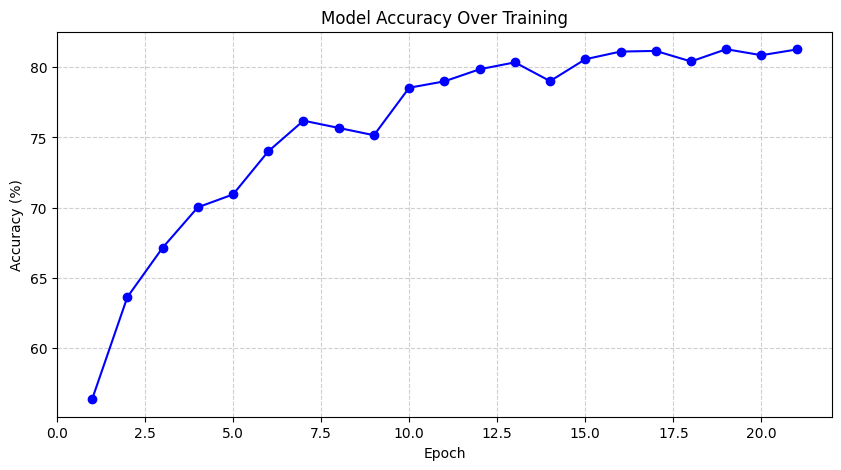

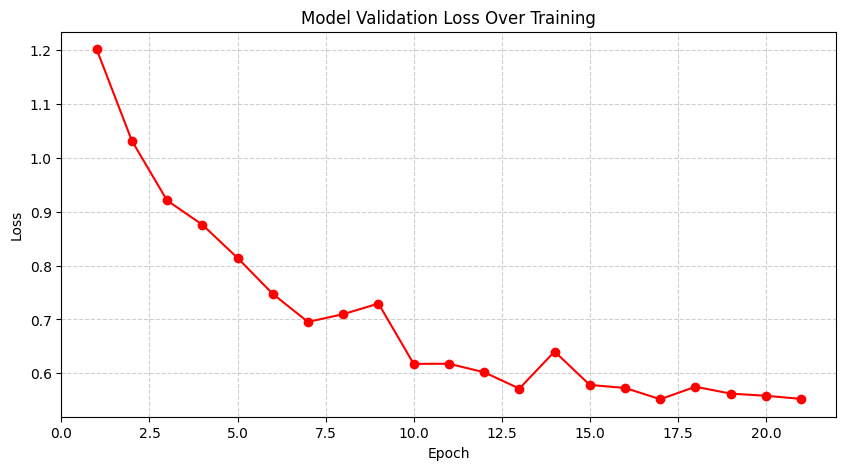

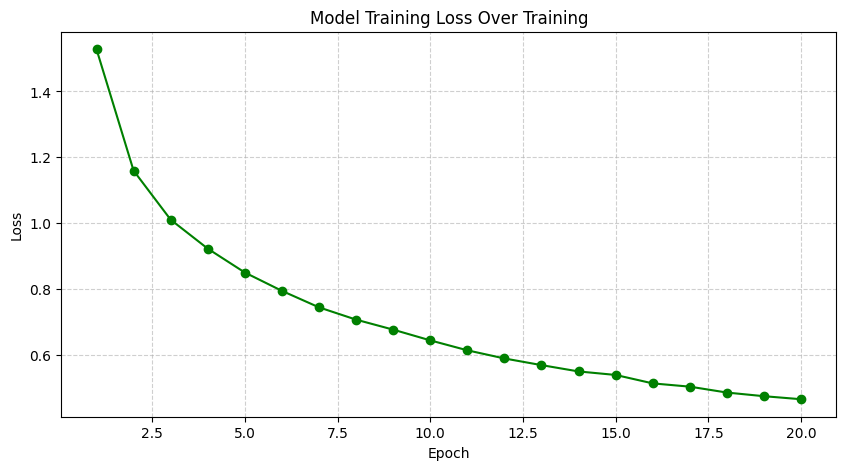

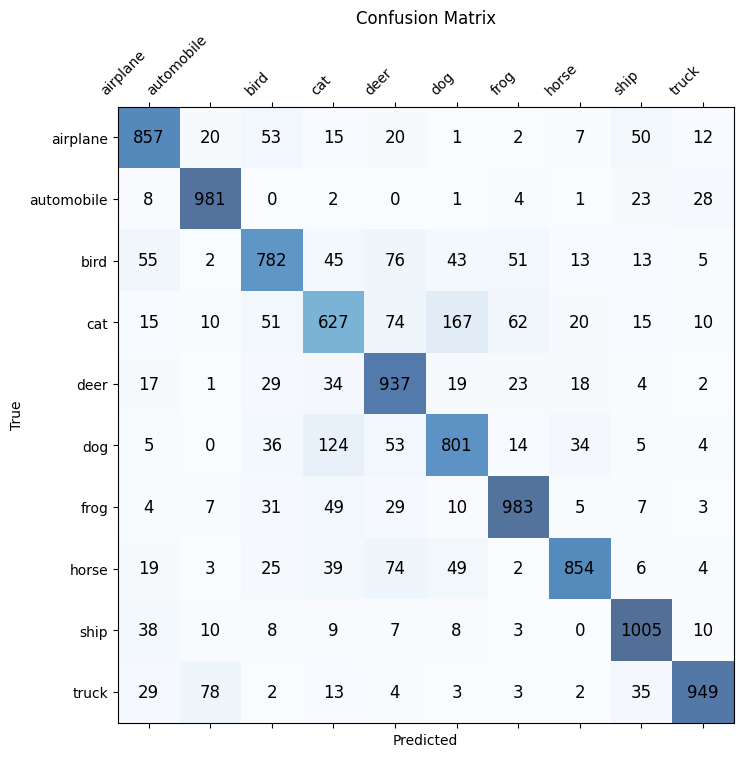


Classification Report:

              precision    recall  f1-score   support

    airplane       0.82      0.83      0.82      1037
  automobile       0.88      0.94      0.91      1048
        bird       0.77      0.72      0.74      1085
         cat       0.66      0.60      0.62      1051
        deer       0.74      0.86      0.79      1084
         dog       0.73      0.74      0.74      1076
        frog       0.86      0.87      0.86      1128
       horse       0.90      0.79      0.84      1075
        ship       0.86      0.92      0.89      1098
       truck       0.92      0.85      0.88      1118

    accuracy                           0.81     10800
   macro avg       0.81      0.81      0.81     10800
weighted avg       0.81      0.81      0.81     10800



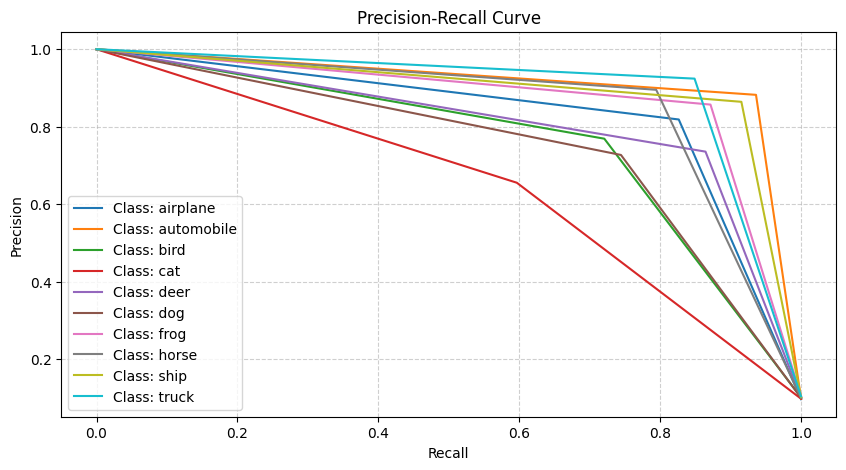

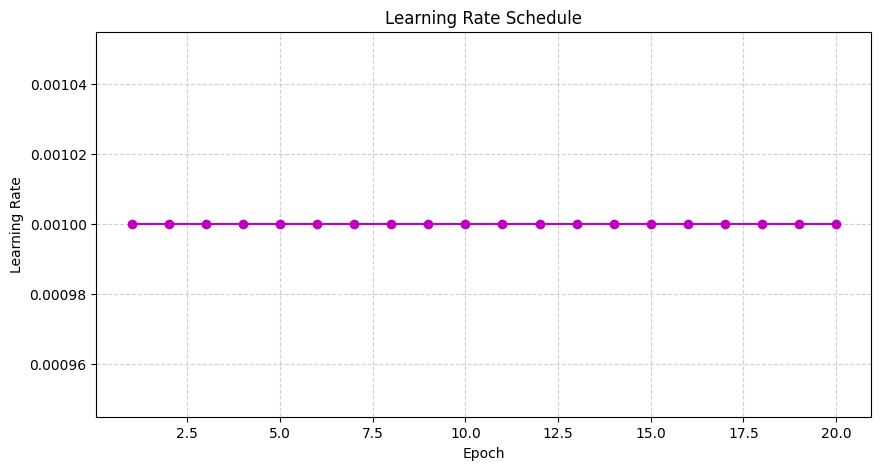

Top-5 Accuracy: 98.84%


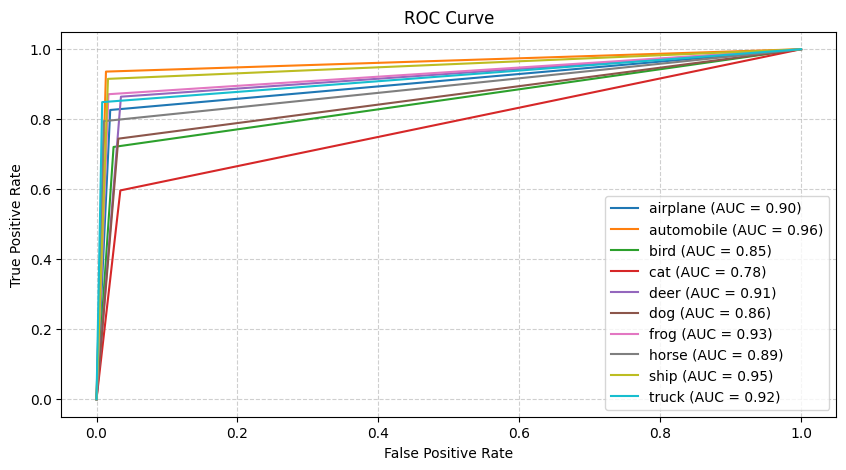

In [20]:
# Improved CNN Model I will only be adding comments which wouldn't be a repeat of the base class ones
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        # Convolutional Layers
        self.convolution1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.normaliseBatch1 = nn.BatchNorm2d(32)
        
        self.convolution2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.normaliseBatch2 = nn.BatchNorm2d(64)
        
        self.convolution3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.normaliseBatch3 = nn.BatchNorm2d(128)
        
        # Added Fourth Convolutional Layer
        self.convolution4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.normaliseBatch4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 2 * 2, 256) # Same as original Model
        self.fc2 = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(0.5) # Same as original Model
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.normaliseBatch1(self.convolution1(x))))
        x = self.pool(self.relu(self.normaliseBatch2(self.convolution2(x))))
        x = self.pool(self.relu(self.normaliseBatch3(self.convolution3(x))))
        x = self.pool(self.relu(self.normaliseBatch4(self.convolution4(x))))
        x = x.view(-1, 256 * 2 * 2) # due to the fourth convolution layer the output channel size increases
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialise Model, Loss, and Optimizer
ImprovedModel = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(ImprovedModel.parameters(), lr=0.001) # Same as original ImprovedModel
#schduler reduces learning rate of the optimiser when teh learning rate stops improving, reduces lr by a factor of 0.5, 
#patience is how long to wait after last improvement to reduce lr again, so if validation loss does not improve after 3 epochs, lr is reduced by a factor of 0.5
#verbose shows a message when lr is reduced 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=3, verbose=True)

# Extract class labels from the original dataset
class_labels = torchvision.datasets.CIFAR10(root='./data', train=True, download=False).classes
 # This will give you the class names
# Create an instance of ModelEvaluator after training
evaluator = ModelEvaluator(ImprovedModel, optimiser, criterion, device, load_train, load_validation, load_test, class_labels)

# Training Loop
epochs =20  # Same as original Model
for epoch in range(epochs):
    ImprovedModel.train()
    running_loss = 0.0
    
    for inputs, labels in load_train:
        inputs, labels = inputs.to(device), labels.to(device)
        optimiser.zero_grad()
        outputs = ImprovedModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()

    # Calculate average training loss and store it
    average_loss = running_loss / len(load_train)
    evaluator.train_losses.append(average_loss)  # Append to evaluator's train_losses
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {average_loss:.4f}")

    # Validation Check
    evaluator.evaluate_epoch(epoch)  # Evaluate on the validation set and store metrics
    evaluator.store_learning_rate()  # Track learning rateoch+1}/{epochs}, Training Loss: {average_loss:.4f}")

    # Validation Check
    ImprovedModel.eval()
    validation_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in load_validation:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ImprovedModel(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_validation_loss = validation_loss / len(load_test)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {average_validation_loss:.4f}, Accuracy: {accuracy:.2f}%")
    scheduler.step(average_validation_loss)
    
# Final Test Accuracy
ImprovedModel.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in load_validation:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ImprovedModel(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate ImprovedModel on the test set
evaluator.evaluate_epoch(epochs - 1)

# Call all evaluation methods
evaluator.plot_accuracy()               # Plot Accuracy
evaluator.plot_validation_loss()        # Plot Validation Loss
evaluator.plot_training_loss()          # Plot Training Loss
evaluator.plot_confusion_matrix()       # Confusion Matrix
evaluator.print_classification_report() # Classification Report
evaluator.plot_precision_recall_curve()# Precision-Recall Curve
evaluator.plot_learning_rate()          # Learning Rate Plot
evaluator.calculate_top5_accuracy()       # Top-5 Accuracy
evaluator.plot_roc_curve()              # ROC Curve


## optimised hyperparameters 

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Training Loss: 1.4575
Epoch 1: Validation Loss: 1.3102, Accuracy: 52.54%
Validation Loss: 2.3644, Accuracy: 52.41%
Epoch 2/50, Training Loss: 1.0787
Epoch 2: Validation Loss: 1.0420, Accuracy: 63.23%
Validation Loss: 1.8719, Accuracy: 63.14%
Epoch 3/50, Training Loss: 0.9268
Epoch 3: Validation Loss: 0.8480, Accuracy: 70.19%
Validation Loss: 1.5210, Accuracy: 70.28%
Epoch 4/50, Training Loss: 0.8388
Epoch 4: Validation Loss: 0.8151, Accuracy: 72.03%
Validation Loss: 1.4562, Accuracy: 72.22%
Epoch 5/50, Training Loss: 0.7678
Epoch 5: Validation Loss: 0.8282, Accuracy: 71.06%
Validation Loss: 1.4989, Accuracy: 70.91%
Epoch 6/50, Training Loss: 0.7205
Epoch 6: Validation Loss: 0.7408, Accuracy: 74.06%
Validation Loss: 1.3290, Accuracy: 74.49%
Epoch 7/50, Training Loss: 0.6780
Epoch 7: Validation Loss: 0.7580, Accuracy: 73.94%
Validation Loss: 1.3960, Accuracy: 73.71%
Epoch 8/50, Training Loss: 0.6509
Epoch 8: Validation Loss: 0.6754, Accuracy: 76.54%
Validation Loss: 1.2143, A

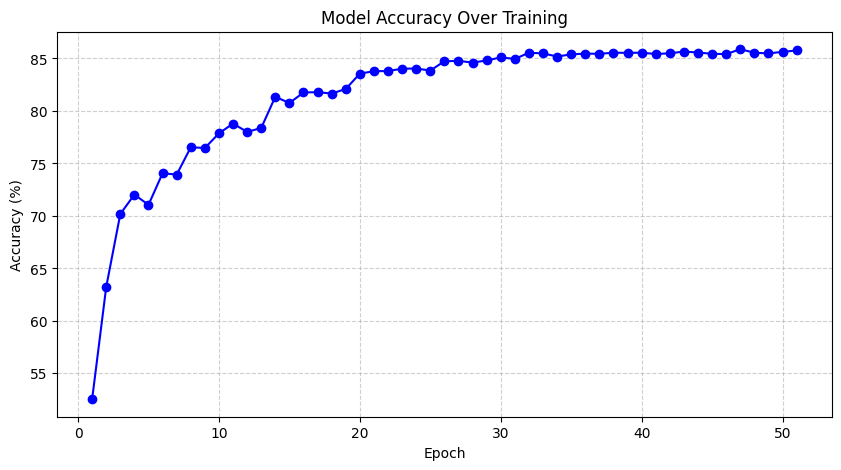

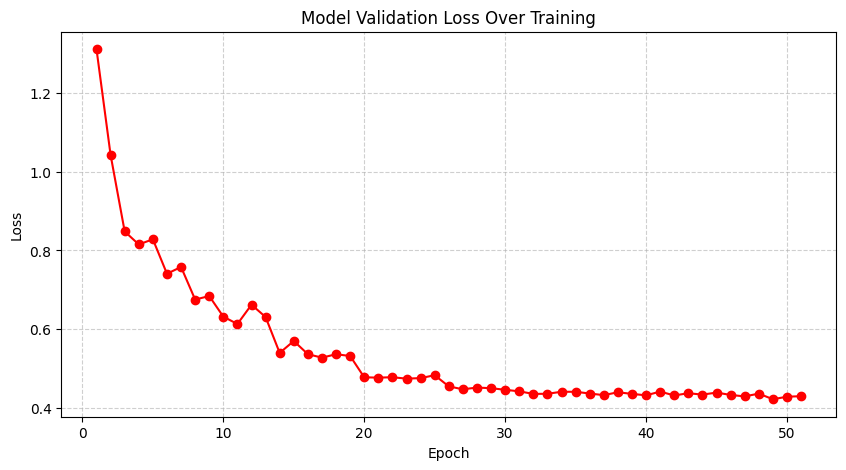

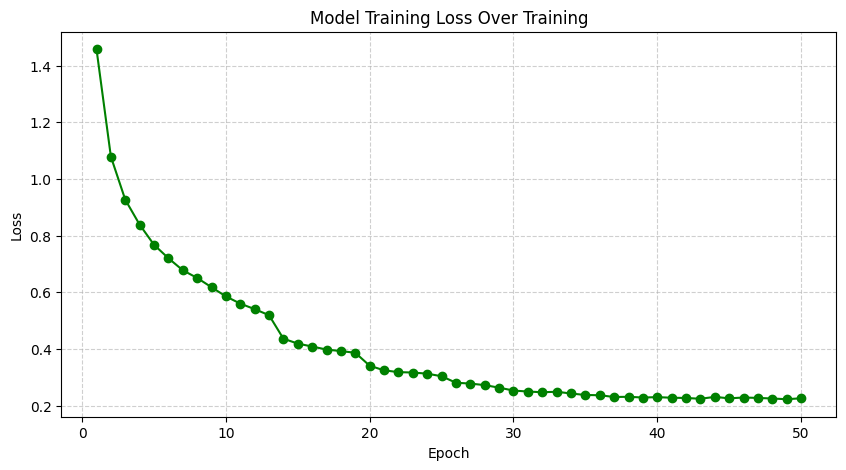

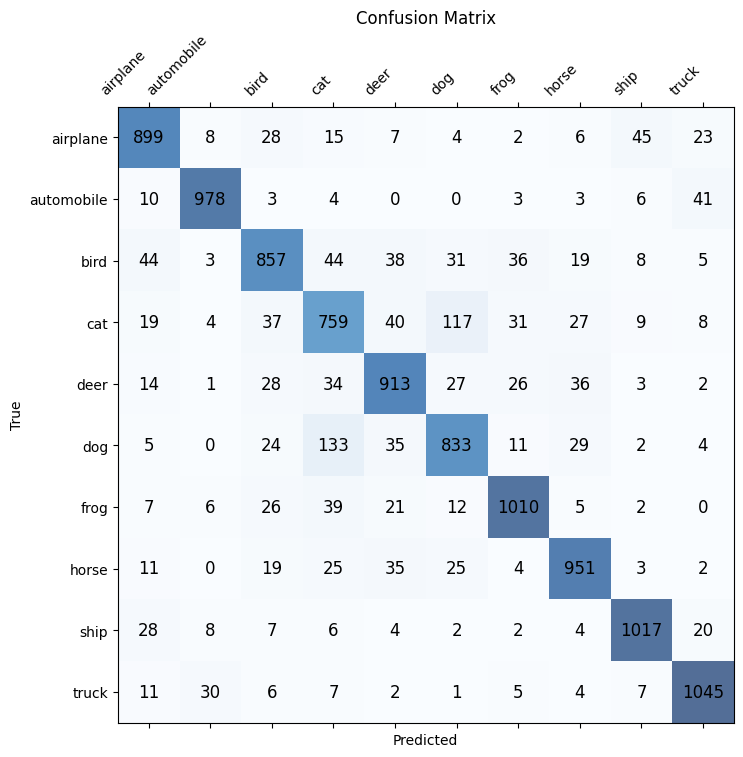


Classification Report:

              precision    recall  f1-score   support

    airplane       0.86      0.87      0.86      1037
  automobile       0.94      0.93      0.94      1048
        bird       0.83      0.79      0.81      1085
         cat       0.71      0.72      0.72      1051
        deer       0.83      0.84      0.84      1084
         dog       0.79      0.77      0.78      1076
        frog       0.89      0.90      0.89      1128
       horse       0.88      0.88      0.88      1075
        ship       0.92      0.93      0.92      1098
       truck       0.91      0.93      0.92      1118

    accuracy                           0.86     10800
   macro avg       0.86      0.86      0.86     10800
weighted avg       0.86      0.86      0.86     10800



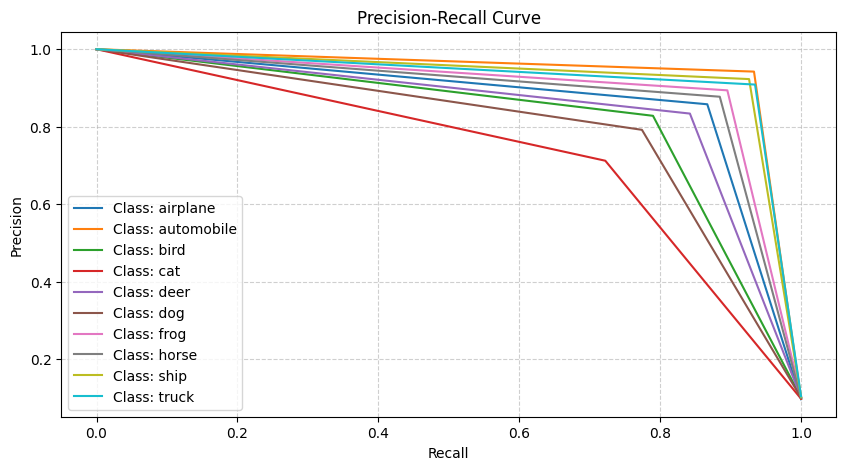

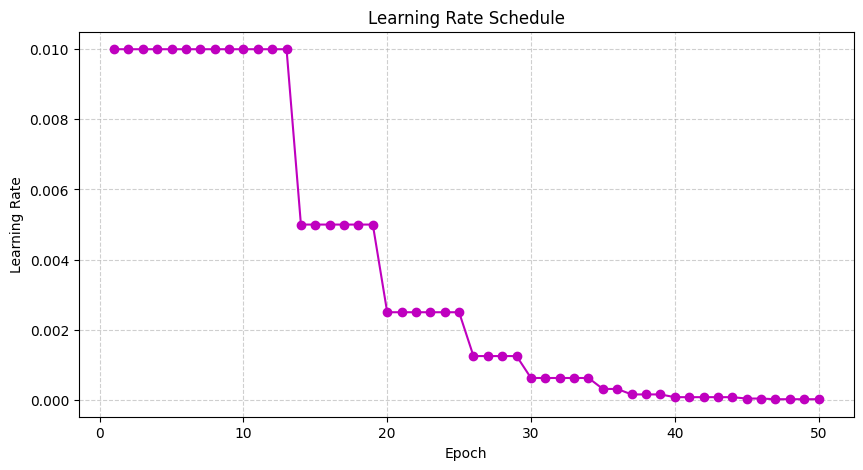

Top-5 Accuracy: 99.35%


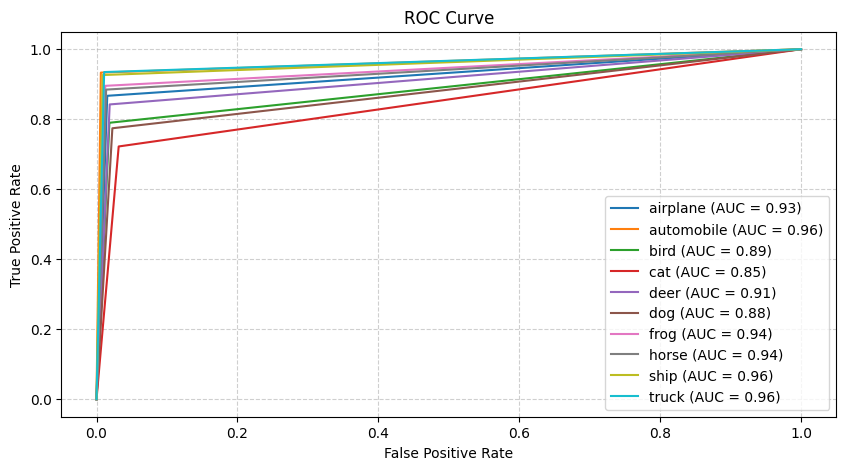

In [50]:
# Updated CNN Model
class OptimisedCNN(nn.Module):
    def __init__(self):
        super(OptimisedCNN, self).__init__()
        # Convolutional Layers
        self.convolution1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.normaliseBatch1 = nn.BatchNorm2d(32)
        
        self.convolution2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.normaliseBatch2 = nn.BatchNorm2d(64)
        
        self.convolution3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.normaliseBatch3 = nn.BatchNorm2d(128)
        
        # Added Fourth Convolutional Layer
        self.convolution4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.normaliseBatch4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)
     #1
        #self.dropout = nn.Dropout(0.5) # 50% of neurons will be dropeed out during each forward pass in training
        #or use this one
        self.dropout = nn.Dropout(0.3) # 30% of neurons will be dropeed out during each forward pass in training

    #2
        #self.relu = nn.ReLU() #defines the activation functiuon ReLU to introduce non linearity, sets negative values to zero and keeps positive values. 
        #or use this one
        self.relu = nn.LeakyReLU(negative_slope=0.1) #leaky ReLU unlike ReLU allows a slight negative slope for negative inputs, preventing neurons from dying keeping them a little active.


    def forward(self, x):
        x = self.pool(self.relu(self.normaliseBatch1(self.convolution1(x))))
        x = self.pool(self.relu(self.normaliseBatch2(self.convolution2(x))))
        x = self.pool(self.relu(self.normaliseBatch3(self.convolution3(x))))
        x = self.pool(self.relu(self.normaliseBatch4(self.convolution4(x))))
        x = x.view(-1, 256 * 2 * 2)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialise Model, Loss, Optimizer, and Scheduler
OptimisedModel = OptimisedCNN().to(device)
criterion = nn.CrossEntropyLoss()

#3
#optimiser = optim.Adam(OptimisedModel.parameters(), lr=0.001) # auto adjusts learning rate for each parameter while training
#or use this one... could further change the learning rate lr to 0.005
optimiser = torch.optim.SGD(OptimisedModel.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4) #traditional optimiser, adjusts parameters uniformly based on gradients, uses momentum and weight decay for stable and efficient updates

#4
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=3, verbose=True) #reduces learning rate when validation loss stops improving, does this dynamically to prevent stagnation
#or this one
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=0.01, steps_per_epoch=len(load_train), epochs= 10) #increases and decreases learning rate in cycles over the entire training, It has a triangular learning rate policy, lr goes up fast in the first phase, then peaks at max_lr and starts decaying to values near zero.


# Extract class labels from the original dataset
class_labels = torchvision.datasets.CIFAR10(root='./data', train=True, download=False).classes
 # This will give you the class names
# Create an instance of ModelEvaluator after training
evaluator = ModelEvaluator(OptimisedModel, optimiser, criterion, device, load_train, load_validation, load_test, class_labels)



# Increase Training Epochs
epochs = 50

# Training Loop
for epoch in range(epochs):
    OptimisedModel.train()
    running_loss = 0.0
    
    for inputs, labels in load_train:
        inputs, labels = inputs.to(device), labels.to(device)
        optimiser.zero_grad()
        outputs = OptimisedModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()

    # Calculate average training loss and store it
    average_loss = running_loss / len(load_train)
    evaluator.train_losses.append(average_loss)  # Append to evaluator's train_losses
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {average_loss:.4f}")

    # Validation Check
    evaluator.evaluate_epoch(epoch)  # Evaluate on the validation set and store metrics
    evaluator.store_learning_rate()  # Track learning rate

    # Update the learning rate scheduler
    scheduler.step(evaluator.validation_losses[-1])  # Step using the last validation loss



    # Validation Check
    OptimisedModel.eval()
    validation_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in load_validation:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = OptimisedModel(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_validation_loss = validation_loss / len(load_test)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {average_validation_loss:.4f}, Accuracy: {accuracy:.2f}%")
    scheduler.step(average_validation_loss)

# Final Test Accuracy
OptimisedModel.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in load_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = OptimisedModel(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate OptimisedModel on the test set
evaluator.evaluate_epoch(epochs - 1)

# Call all evaluation methods
evaluator.plot_accuracy()               # Plot Accuracy
evaluator.plot_validation_loss()        # Plot Validation Loss
evaluator.plot_training_loss()          # Plot Training Loss
evaluator.plot_confusion_matrix()       # Confusion Matrix
evaluator.print_classification_report() # Classification Report
evaluator.plot_precision_recall_curve()# Precision-Recall Curve
evaluator.plot_learning_rate()          # Learning Rate Plot
evaluator.calculate_top5_accuracy()       # Top-5 Accuracy
evaluator.plot_roc_curve()              # ROC Curve

## Testing models on test set, and evaluate those results


Starting Test Evaluation and Comparison...

Testing Model: Base CNN
Model: Base CNN
Test Loss: 0.6708
Accuracy: 77.55%
Top-5 Accuracy: 98.43%

Classification Report for Base CNN:

              precision    recall  f1-score   support

    airplane       0.76      0.82      0.79       600
  automobile       0.84      0.93      0.88       579
        bird       0.77      0.59      0.67       622
         cat       0.62      0.61      0.62       583
        deer       0.66      0.82      0.73       580
         dog       0.75      0.63      0.68       621
        frog       0.82      0.87      0.84       571
       horse       0.75      0.88      0.81       642
        ship       0.93      0.80      0.86       586
       truck       0.91      0.81      0.86       616

    accuracy                           0.78      6000
   macro avg       0.78      0.78      0.77      6000
weighted avg       0.78      0.78      0.77      6000


-----------------------------------------------------------

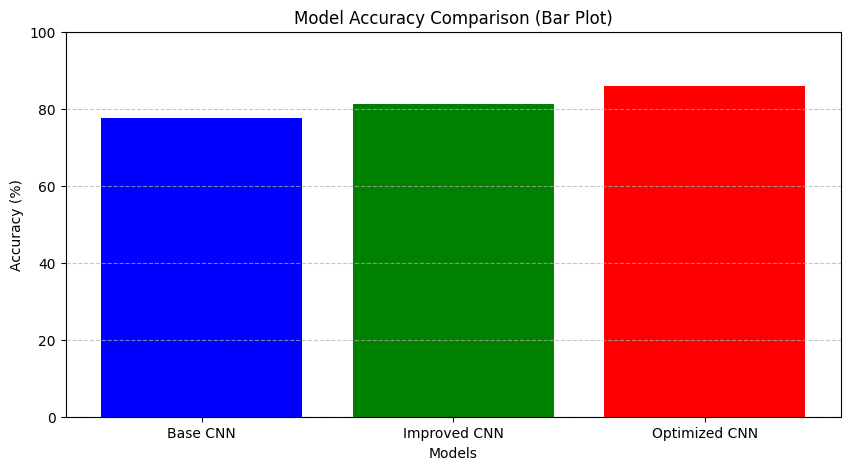

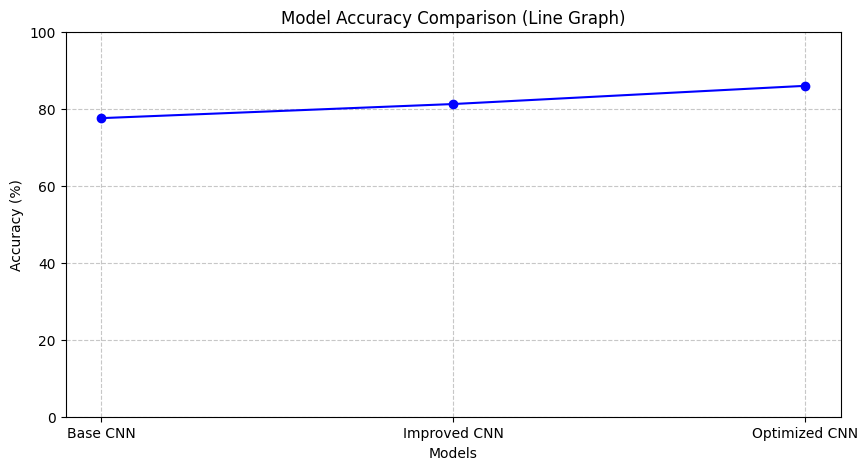

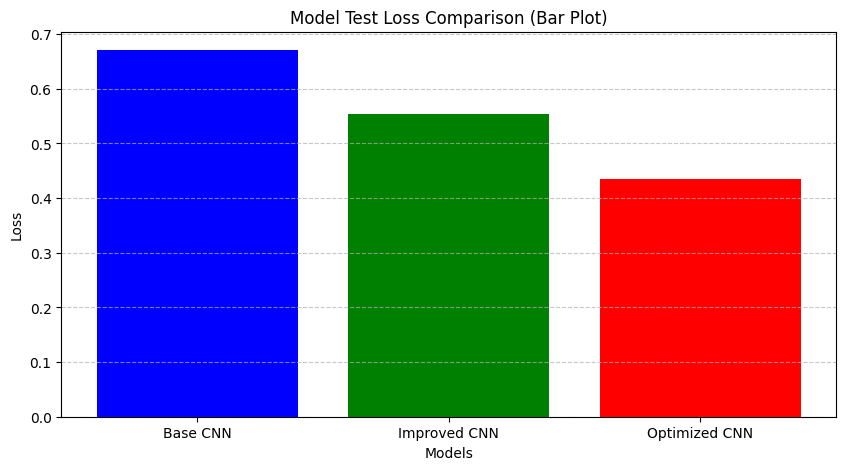

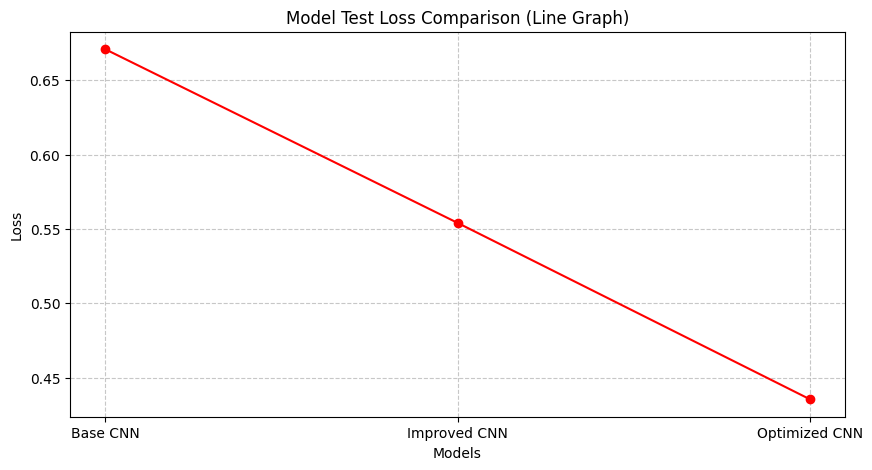

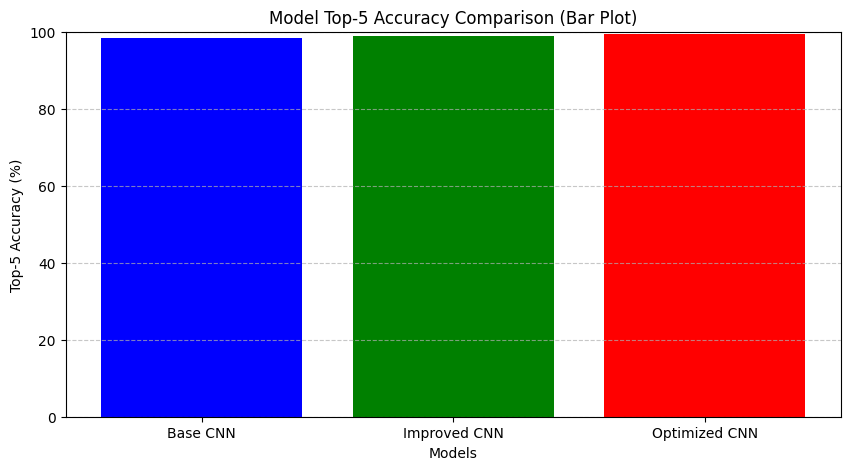

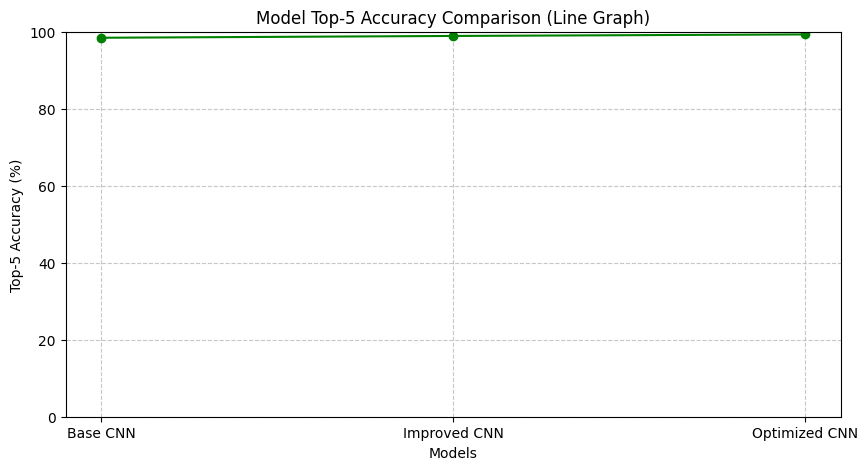

In [31]:

def test_and_compare_models(models, model_names, load_test, class_labels, criterion):
    print("\nStarting Test Evaluation and Comparison...\n")
    test_results = {}

    # Test each model on the test data
    for model, name in zip(models, model_names):
        print(f"Testing Model: {name}")
        model.eval()  # Switch to evaluation mode
        test_loss = 0.0
        correct, total = 0, 0
        correct_top5, total_top5 = 0, 0
        all_labels, all_predictions = [], []

        with torch.no_grad():
            for inputs, labels in load_test:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                _, top5_predictions = outputs.topk(5, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                correct_top5 += (top5_predictions == labels.unsqueeze(1)).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        # Compute metrics
        accuracy = 100 * correct / total
        top5_accuracy = 100 * correct_top5 / total
        average_test_loss = test_loss / len(load_test)

        # Print metrics to terminal
        print(f"Model: {name}")
        print(f"Test Loss: {average_test_loss:.4f}")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")
        print(f"\nClassification Report for {name}:\n")
        print(classification_report(all_labels, all_predictions, target_names=class_labels))

        # Store results
        test_results[name] = {
            "Test Loss": average_test_loss,
            "Accuracy": accuracy,
            "Top-5 Accuracy": top5_accuracy,
            "Confusion Matrix": confusion_matrix(all_labels, all_predictions),
            "Classification Report": classification_report(all_labels, all_predictions, target_names=class_labels, output_dict=True)
        }
        print("\n" + "-"*60 + "\n")

    # Compare results with bar plots and line graphs
    print("\nGenerating Comparative Plots...\n")

    # Extract metrics for all models
    accuracies = [test_results[name]["Accuracy"] for name in model_names]
    test_losses = [test_results[name]["Test Loss"] for name in model_names]
    top5_accuracies = [test_results[name]["Top-5 Accuracy"] for name in model_names]

    # Accuracy Comparison - Bar Plot and Line Graph
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
    plt.title("Model Accuracy Comparison (Bar Plot)")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Models")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(model_names, accuracies, marker='o', linestyle='-', color='b')
    plt.title("Model Accuracy Comparison (Line Graph)")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Models")
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Test Loss Comparison - Bar Plot and Line Graph
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, test_losses, color=['blue', 'green', 'red'])
    plt.title("Model Test Loss Comparison (Bar Plot)")
    plt.ylabel("Loss")
    plt.xlabel("Models")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(model_names, test_losses, marker='o', linestyle='-', color='r')
    plt.title("Model Test Loss Comparison (Line Graph)")
    plt.ylabel("Loss")
    plt.xlabel("Models")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Top-5 Accuracy Comparison - Bar Plot and Line Graph
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, top5_accuracies, color=['blue', 'green', 'red'])
    plt.title("Model Top-5 Accuracy Comparison (Bar Plot)")
    plt.ylabel("Top-5 Accuracy (%)")
    plt.xlabel("Models")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(model_names, top5_accuracies, marker='o', linestyle='-', color='g')
    plt.title("Model Top-5 Accuracy Comparison (Line Graph)")
    plt.ylabel("Top-5 Accuracy (%)")
    plt.xlabel("Models")
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    return test_results

# List of trained models and their names
models = [CNNModel, ImprovedModel, OptimisedModel]  # Ensure these are valid model instances
model_names = ["Base CNN", "Improved CNN", "Optimized CNN"]

# Run the test and comparison
test_results = test_and_compare_models(models, model_names, load_test, class_labels, criterion)
